<hr style="height:5px;border-width:0;color:orange;background-color:orange">
    <center> <span style="font-size: 38px;"> Microsoft Malware Prediction </span> </center>

+ Author: **Alejandro Sánchez Silvestre**
+ Date: **February 2024**
+ Module: **Machine Learning: Classifier**

<hr style="height:5px;border-width:0;color:orange;background-color:orange">


## Intro
El conjunto de datos se ha obtenido mediante el muestreo y la adaptación del original del concurso de
Kaggle Microsoft Malware Prediction. Cada fila del dataset corresponde a una única máquina,
identificada por el campo MachineIdentifier. El target es la variable **HasDetections**, que indica si se ha
detectado la infección de la máquina por el malware.

Los datos pueden descargarse en el siguiente enlace: 
https://drive.google.com/file/d/1ikHxdS6cEUvVBJHWMFdgJHBS9bebEOxs/view?usp=sharing



OBJETIVO

Desarrollar un proyecto de modelización supervisada para predecir la probabilidad de infección de un
ordenador con Windows. 

**ROAD MAP Y OUTLINE**: 
- **Intro**
- **Pipeline summary**: 
    1. **Comprensión del problema/negocio**
    2. **Entendimiento de los datos**
    3. **Preprocesamiento**
    4. **Modelización**: Baseline
    5. **First Iteration**: XGBoost con 7 features importantes + target
    6. **Second Iteration**: Lista de 3 modelos (Random Forest, Gradient Boosting y XGBoost) con 7 features + target.
    7. **Third Iteration**: XGBoost optimizado con hiperparametros  y entrenado con datos ampliados (20 col + target)
- **Conclusion**





<hr style="height:5px;border-width:0;color:orange;background-color:orange">


<a id='seccion1'></a>
## **1. Comprension del Problema/Negocio**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

El dataset contienen información sobre las caracteristicas de distintos ordenadores (MachineIdentifier) así como si ha sido infectado o no por malware (HasDetections)

Evaluaremos:
-	Columnas dataset: siginificado de cada una
-	Definir hipótesis previa
-	Algoritmo ML a utilizar para resolver problema

### 1.1 Import Libaries

In [1]:
# Importamos las bibliotecas necesarias
# Generales
import pandas as pd
import numpy as np

# Visualización y EDA
import matplotlib.pyplot as plt
import seaborn as sns  
import plotly.express as px
import skimpy as sk



# importamos los distintos modelos a utilizar
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# y las metricas a utilizar ya las importamos antes...

# dividimos train test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


import random

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


from sklearn.model_selection import RepeatedKFold, cross_validate

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


import warnings

# Ignorar todos los warnings
warnings.filterwarnings("ignore")




In [2]:
df= pd.read_csv('sample_mmp.csv',encoding='UTF-8',sep=',',index_col=0).reset_index(drop=True)
df
# Atencion nos informa que en columnas 29 y 42 tenemos datos mixtos...transformaremos los datos acorde a las columnas.


C:\Users\Usuario\AppData\Local\Temp\ipykernel_16712\2103149277.py:1: DtypeWarning: Columns (29,42) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('sample_mmp.csv',encoding='UTF-8',sep=',',index_col=0).reset_index(drop=True)


,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.0,0,NaN,53447.0,...,19951.0,0,NaN,0.0,0,0,0.0,0.0,11.0,1
1,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.0,0,NaN,53447.0,...,48753.0,0,0.0,0.0,0,0,0.0,1.0,3.0,0
2,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.0,0,NaN,46781.0,...,33111.0,1,0.0,0.0,1,1,0.0,0.0,15.0,0
3,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.0,0,NaN,53447.0,...,48473.0,1,NaN,0.0,0,0,0.0,0.0,15.0,1
4,06ca8fa8d32c2abdc5b3577d676b3269,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,0,7.0,0,NaN,47238.0,...,4343.0,1,NaN,0.0,1,0,0.0,1.0,13.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,a739cacc292f3f1e745827c1ca6c6ada,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1090.0,0,7.0,0,NaN,53447.0,...,33088.0,1,0.0,0.0,1,0,0.0,1.0,10.0,0
499996,a4c232d528d98343e8f1b73650da7b82,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1620.0,0,7.0,0,NaN,53447.0,...,NaN,0,NaN,0.0,0,0,0.0,0.0,15.0,0
499997,fd16cd542d660848d272e4552bcccb1e,win8defender,1.1.15300.5,4.13.17134.112,1.275.1343.0,0,7.0,0,NaN,53447.0,...,41727.0,0,NaN,0.0,0,0,0.0,0.0,8.0,0
499998,fa0841f8f6147de7c3d287e05270ed42,win8defender,1.1.15100.1,4.14.17639.18041,1.273.483.0,0,7.0,0,NaN,43856.0,...,11947.0,0,NaN,0.0,0,0,0.0,0.0,1.0,0


In [3]:
# Identificamos las columas que tienen tipos mixtos para dejarlas como un solo tipo.

print('Columnas tipos mixtos: ',df.columns[29],' y ',df.columns[42])

Columnas tipos mixtos:  SMode  y  Census_PrimaryDiskTotalCapacity


In [4]:
df.SMode.describe()

count    470152.000000
mean          0.000438
std           0.020928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: SMode, dtype: float64

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# cambiamos la opcion para que no muestre la notacion cientifica.

df.Census_PrimaryDiskTotalCapacity.describe()

count     497024.00
mean      514043.32
std       370446.82
min        10240.00
25%       239372.00
50%       476940.00
75%       953869.00
max     47687668.00
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

In [6]:
# Convertimos columna SMode a tipo float(variable binaria)
df.SMode= df.SMode.astype(float)
# y lo mismo hacemos con la otra columna, nos aseguramos que lo pasamos a tipo float. En este caso es una variable numerica continua.
df.Census_PrimaryDiskTotalCapacity = df.Census_PrimaryDiskTotalCapacity.astype(float)

In [7]:
df.head()

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.00,0,NaN,53447.00,...,19951.00,0,NaN,0.00,0,0,0.00,0.00,11.00,1
1,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.00,0,NaN,53447.00,...,48753.00,0,0.00,0.00,0,0,0.00,1.00,3.00,0
2,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.00,0,NaN,46781.00,...,33111.00,1,0.00,0.00,1,1,0.00,0.00,15.00,0
3,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.00,0,NaN,53447.00,...,48473.00,1,NaN,0.00,0,0,0.00,0.00,15.00,1
4,06ca8fa8d32c2abdc5b3577d676b3269,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,0,7.00,0,NaN,47238.00,...,4343.00,1,NaN,0.00,1,0,0.00,1.00,13.00,1


In [8]:
df.columns

# tenemos la tira de columnas y no sabemos qué significa cada una. Buscaremos informacion en Kaggle sobre este aspecto para ver si podemos enterarnos un poco mas a fin de identificar 
# qué columnas son de importancia y cuales no a fin de reducir las columnas(82 son demasiadas  para introducir en nuestro modelo ML)

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

###  1.2 Detalle Significado Columna

Siguiendo el esquema inicial, indagamos sobre la informacion que contienen cada una de las 82 columnas:

Resumiendo, las columnas parecen se referirse tanto a datos de software como hardware de las distintas maquinas así como localizacion, uso o compañía.

_Primera hipotesis_ que me sugieren la info:

Basandonos en un ligero conocimiento sobre malware hipotizamos que los datos sobre el sistema antivirus, el sistema operativo, el buscador usado para internet, la localizacion de la maquina(pais, region) y pertenencia a una compañia si existe un firewall y otros tipos…podrian tener implicacion en la infeccion de malware

Poniendonos en la piel de un Hacker interesaría hackear maquinas de **lugares ricos** (compañías de gran facturación, paises desarrollados..) donde fuera  lo mas facil posible (caracteristicas del **software** de la maquina como OS, si tiene antivirus, buscador...) obtener datos, hackear y o bien pedir dinero a la compañía por evitar un mal mayor. Sin embargo a un hacker poco le importa si la maquina tiene un disco duro de disco CD/DVD (Census_HasOpticalDiskDrive) o el numero de nucleos logicos del procesador( Census_ProcessorCoreCount)... es decir la mayoria de caracteristicas de **hardware** a priori no las consideraría claves.


A través de Kaggle (https://www.kaggle.com/c/microsoft-malware-prediction/data) hemos conseguido la información de cada columna. Extraeremos las variables que nos parecen sospechosas sin antes ver datos por hacer una exploración

- MachineIdentifier - Individual machine ID
- **ProductName** - Defender state information e.g. win8defender
- **EngineVersion** - Defender state information e.g. 1.1.12603.0
- **AppVersion** - Defender state information e.g. 4.9.10586.0
- **AvSigVersion** - Defender state information e.g. 1.217.1014.0
- **DefaultBrowsersIdentifier** - ID for the machine's default browser
- **AVProductStatesIdentifier** - ID for the specific configuration of a user's antivirus software
- **HasTpm** - True if machine has tpm
- **CountryIdentifier** - ID for the country the machine is located in
- **OrganizationIdentifier** - ID for the organization the machine belongs in, organization ID is mapped to both specific companies and broad industries
- **OsVer** - Version of the current operating system
- **OsPlatformSubRelease** - Returns the OS Platform sub-release (Windows Vista, Windows 7, Windows 8, TH1, TH2)
- **IsProtected** - This is a calculated field derived from the Spynet Report's AV Products field. Returns: a. TRUE if there is at least one active and up-to-date antivirus product running on this machine. b. FALSE if there is no active AV product on this machine, or if the AV is active, but is not receiving the latest updates. c. null if there are no Anti Virus Products in the report. Returns: Whether a machine is protected.
- **Firewall** - This attribute is true (1) for Windows 8.1 and above if windows firewall is enabled, as reported by the service.
- **UacLuaenable** - This attribute reports whether or not the "administrator in Admin Approval Mode" user type is disabled or enabled in UAC. The value reported is obtained by reading the regkey HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Policies\System\EnableLUA.
- **Census_OSArchitecture** - Architecture on which the OS is based. Derived from OSVersionFull. Example - amd64
- **Census_OSSkuName** - OS edition friendly name (currently Windows only)
- **Census_OSWUAutoUpdateOptionsName** - Friendly name of the WindowsUpdate auto-update settings on the machine.
- **Census_IsSecureBootEnabled** - Indicates if Secure Boot mode is enabled.
- **Census_IsVirtualDevice** - Identifies a Virtual Machine (machine learning model)
- **Census_IsPenCapable** - Is the device capable of pen input ?
- **Census_IsAlwaysOnAlwaysConnectedCapable** - Retreives information about whether the battery enables the device to be AlwaysOnAlwaysConnected .
- **Wdft_IsGamer** - Indicates whether the device is a gamer device or not based on its hardware combination.

- **HasDetections** ES LA **VARIABLE TARGET A PREDECIR**. Significa si la maquina detectó la infeccion de malware

### 1.3 **Algoritmo a utilizar para resolver el problema**

El problema que debemos resolver se trata de la predicción sobre la infeccion de malware de un ordenador (target categórico/binario). 

De momento podemos adelantar que usaremos un algoritmo de ML supervisado de Clasificación.

Las métricas que utilizaremos para la evaluación de resultados serán: Accuracy, Precision, Recall, F1-Score	y AUC-ROC. Dada la naturaleza del problema considero que debemos hacer enfasis en detectar el mayor numero de True Positives. Pasar por alto un positivo (False negative) hará ese ordenador incluso más potencialmente peligroso ya que lo considerariamos ''sano'' cuando no lo es. Es por ello que el Recall será una metrica que nos ayudará mas a capturar el mayor numero de True Positives y reducir la tasa de Falsos negativos (Error tipo II)


<a id='seccion2'></a>
## **2. Entendimiento de los datos**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

El tamaño del dataset podemos decir que es lo suficientemente grande (500.000 observaciones y 82 columnas) para la modelización de ML. 

Respecto a la hipotesis inicial antes mencionada deberemos abandonarla por el momento ya que la mayoria de las columnas descriptivas que nos parecieron ''importantes'' estan codificadas, por poner un ejemplo, CountryIdentifier y CityIdentifier, corresponen a numeros y no lugares detallados y no he encontrado una lista que nos pueda sugerir ninguna pista.

Los proximos pasos son:
- EDA univariante
- EDA multivariante
- Correlacion variables con variable target
- Visualizacion distribucion de las variables


In [9]:
df.shape

(500000, 83)

In [10]:
'''

import pandas as pd
from ipywidgets import widgets
from ydata_profiling import ProfileReport # https://docs.profiling.ydata.ai/4.6/
from ydata_profiling.utils.cache import cache_file

'''

'\n\nimport pandas as pd\nfrom ipywidgets import widgets\nfrom ydata_profiling import ProfileReport #\xa0https://docs.profiling.ydata.ai/4.6/\nfrom ydata_profiling.utils.cache import cache_file\n\n'

In [11]:
# EDA (Exploratory Data Analysis) Report

'''
profile = ProfileReport(df, 
                        title='EDA malware prediction', 
                        correlations={
                            "auto": {"calculate": True},
                            "spearman": {"calculate": False}
                            # "phi_k": False
                        })
profile.to_widgets()
'''

'\nprofile = ProfileReport(df, \n                        title=\'EDA malware prediction\', \n                        correlations={\n                            "auto": {"calculate": True},\n                            "spearman": {"calculate": False}\n                            # "phi_k": False\n                        })\nprofile.to_widgets()\n'

In [12]:
# Export to html
# profile.to_file("eda_output.html")

### **2.1 EDA univariable**

Usamos Skympy para hacer un EDA univariable.
Con esta herramienta no solo podemos ver el .shape de nuestro df, sino mas datos como la distribucion de los datos, % de nulos por columnas, media, sd y los percentiles



Tras un vistazo inicial nos ha llamado la atención:
- Alta proporcion de Nulos en algunas columnas. 
- Existencia columnas donde apenas hay variacion en los datos o existe mucha.
- Columnas que podrian comportarse de forma binaria. 

Todo esto lo veremos mas en detalle en el apartado de preprocesamiento.

In [13]:

sk.skim(df)


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 500000 │ │ float64     │ 36    │                                                          │
│ │ Number of columns │ 83     │ │ string      │ 30    │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 17    │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_n ┃        ┃       ┃          ┃           ┃       ┃        ┃        ┃          ┃           ┃        ┃  │
│ ┃ ame      ┃ NA     ┃ NA %  ┃ mean     ┃ sd        ┃ p0    ┃ p25    ┃ p50    ┃ p75      ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ IsBeta   │      0 │     0 │    2e-06 │    0.0014 │     0 │      0 │      0 │        0 │         1 │   ▇    │  │
│ │ RtpState │   1832 │  0.37 │      6.8 │         1 │     0 │      7 │      7 │        7 │        35 │    ▇   │  │
│ │ Bitfield │        │       │          │           │       │        │        │          │           │        │  │
│ │ IsSxsPas │      0 │     0 │    0.017 │      0.13 │     0 │      0 │      0 │        0 │         1 │   ▇    │  │
│ │ siveMode │        │       │          │           │       │        │        │          │           │        │  │
│ │ DefaultB │ 475939 │ 95.19 │     1700 │      1000 │     1 │    790 │   1600 │     2400 │      3200 │ ▆▂▃▇▃▆ │  │
│ │ rowsersI │        │       │          │           │       │        │        │          │           │        │  │
│ │ dentifie │        │       │          │           │       │        │        │          │           │        │  │
│ │ r        │        │       │          │           │       │        │        │          │           │        │  │
│ │ AVProduc │   1938 │  0.39 │    48000 │     14000 │     3 │  49000 │  53000 │    53000 │     70000 │ ▁  ▁▇▁ │  │
│ │ tStatesI │        │       │          │           │       │        │        │          │           │        │  │
│ │ dentifie │        │       │          │           │       │        │        │          │           │        │  │
│ │ r        │        │       │          │           │       │        │        │          │           │        │  │
│ │ AVProduc │   1938 │  0.39 │      1.3 │      0.52 │     1 │      1 │      1 │        2 │         5 │   ▇▃   │  │
│ │ tsInstal │        │       │          │           │       │        │        │          │           │        │  │
│ │ led      │        │       │          │           │       │        │        │          │           │        │  │
│ │ AVProduc │   1938 │  0.39 │        1 │      0.17 │     0 │      1 │      1 │        1 │         4 │    ▇   │  │
│ │ tsEnable │        │       │          │           │       │        │        │          │           │        │  │
│ │ d        │        │       │          │           │       │        │        │          │           │        │  │
│ │ HasTpm   │      0 │     0 │     0.99 │      0.11 │     0 │      1 │      1 │        1 │         1 │      ▇ │  │
│ │ CountryI │      0 │     0 │      110 │        63 │  

In [14]:
# Comprobamos la distribucion de la variable target, si tenemos datos balanceados o no.
df.HasDetections.value_counts(normalize=True)

# y efectivamente nuestra variable target esta balanceada (50-50).

HasDetections
0   0.50
1   0.50
Name: proportion, dtype: float64

### 2.2 EDA bivariable

Aqui la idea es visualizar tanto la distribucion de las variables numericas y categoricas y tambien observar como se comportan estas respecto al target.

Despues de analizar las graficas podemos sacar los siguientes insights:
- Las variables 'City_Identifier' y 'Country_Identifier' existen algunos valores con mayor proporcion de infectados que el resto. Esto podria tener sentido con la hipotesis inicial que mencionabamos respecto al target del hackeo centrado en paises o zonas ricas.
- La variable 'Default_Browser_Idenfifier' hay un valor que destaca frente al resto con mas infectados
- La variable 'Is_protected' destaca que los valores 0 tienen mayor proporcion de infectados respecto a los 1

- Engine version: hay un valor en particular que destaca por tener mas infectados
- Smart_screen: cuando figura 'ExistNotSet' hay mayor porporcion de infectados.
- Census processor class: cuando figura 'high' como valor hay mayor porporcion de infectados

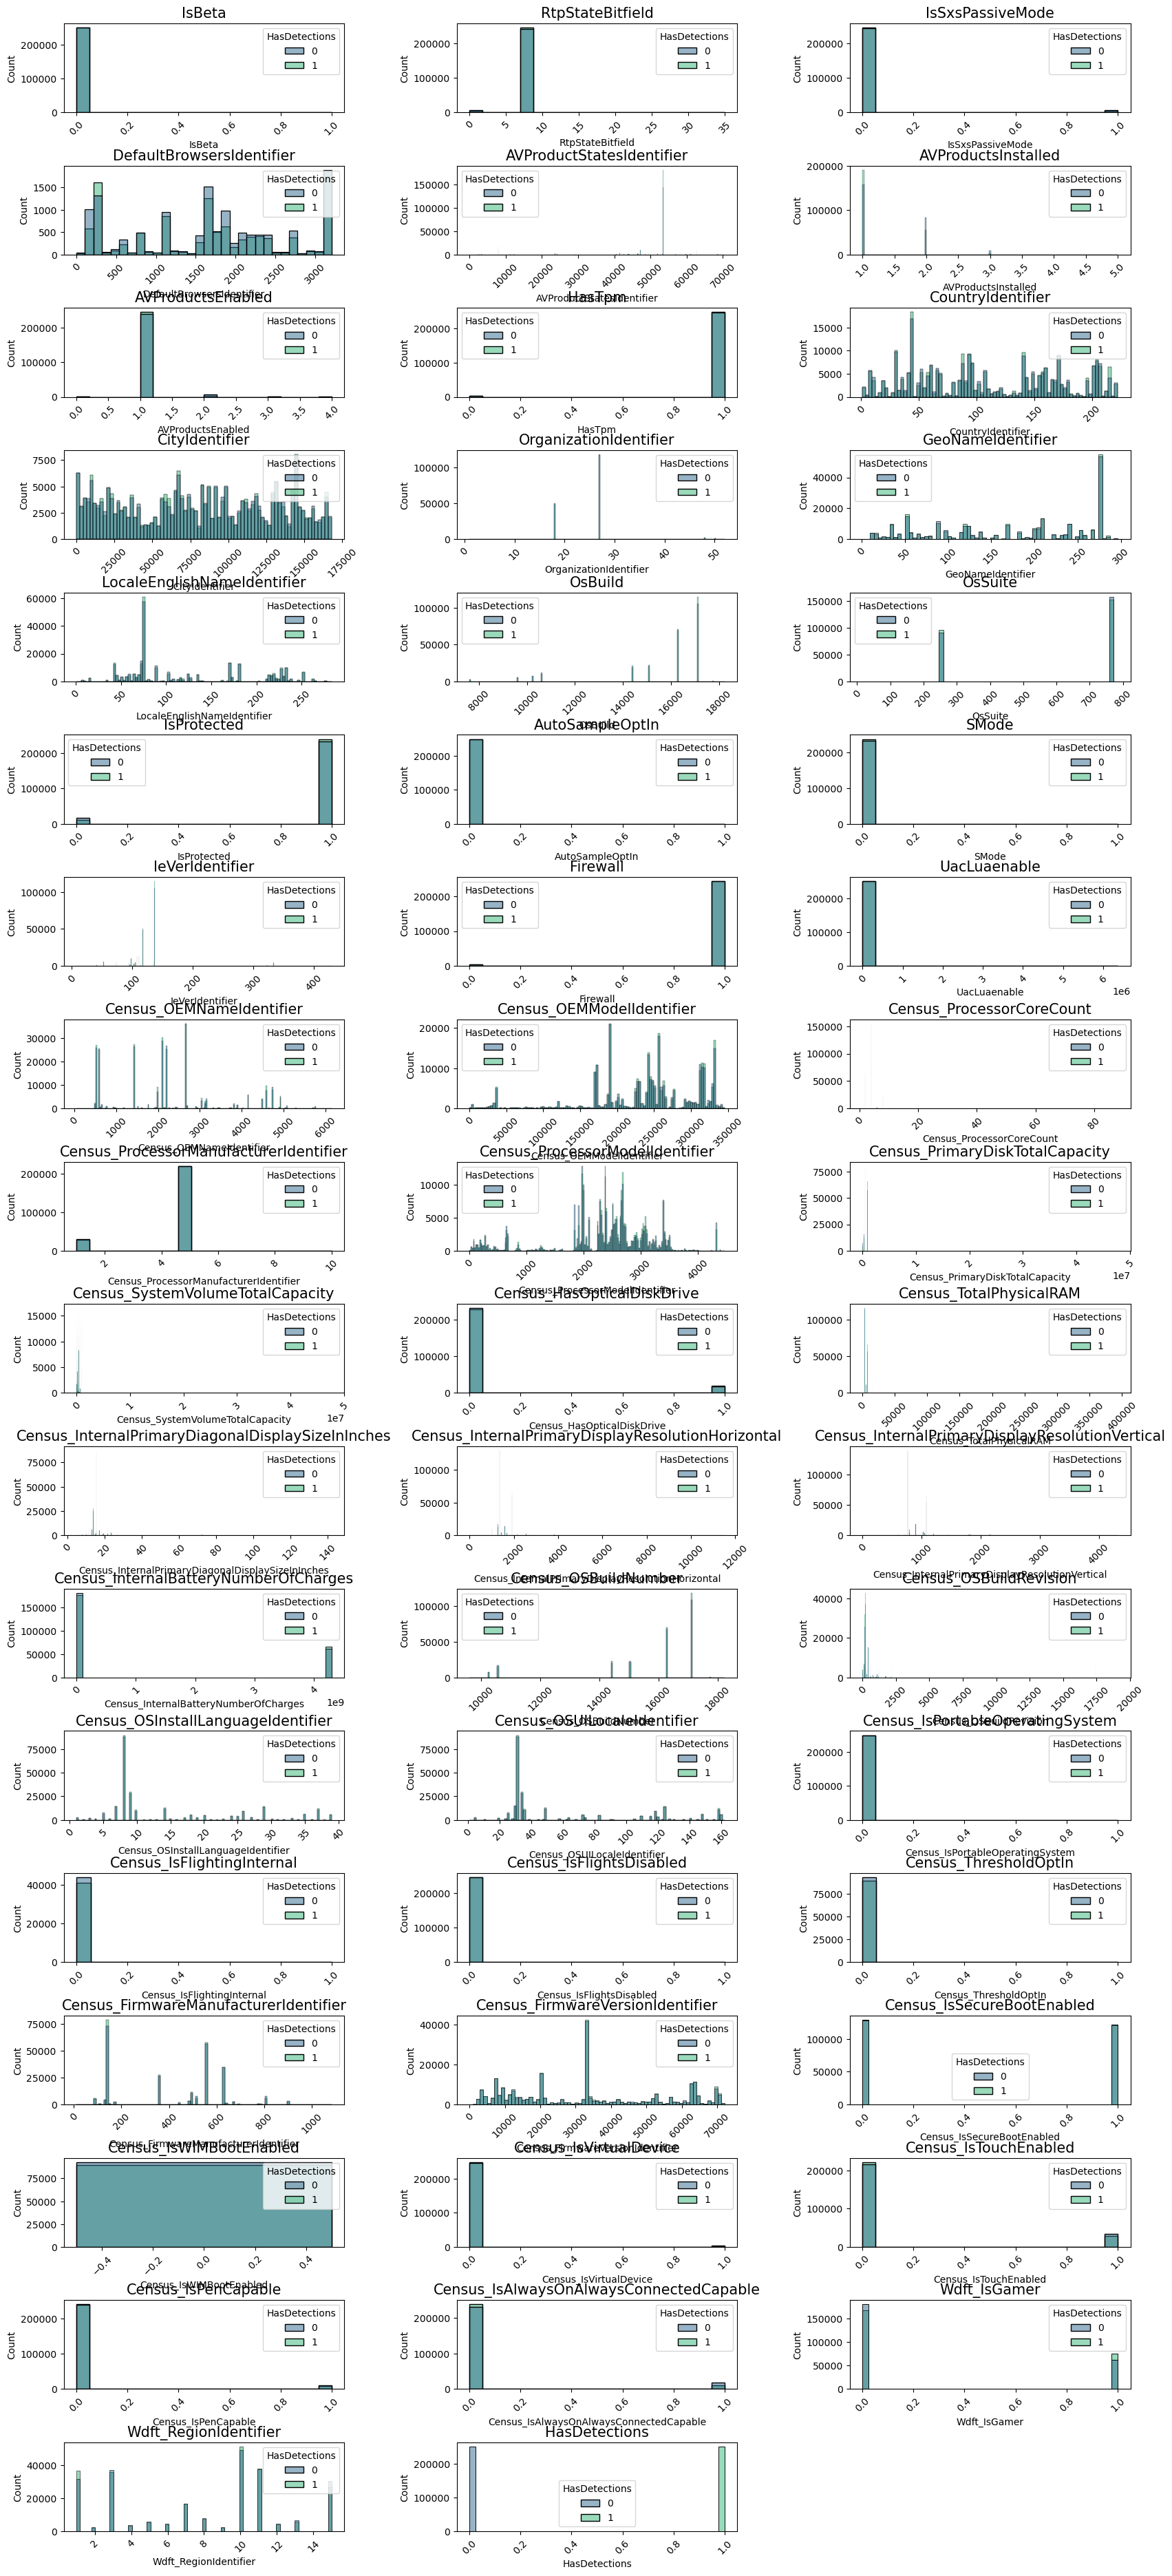

In [15]:
# Veremos la distribucion de las variables numericas y como se comportan con el target

df_num=df.select_dtypes(include='number')
plt.figure(figsize=(20,50))
for i, col in enumerate(df_num.columns):
    plt.subplot(19,3,i+1)
    sns.histplot(data= df_num,x=col,hue='HasDetections',palette='viridis')
    plt.xticks(rotation=45,fontsize=10)
    plt.title(col,fontsize=15)
    plt.subplots_adjust(wspace=0.4, hspace=0.6)

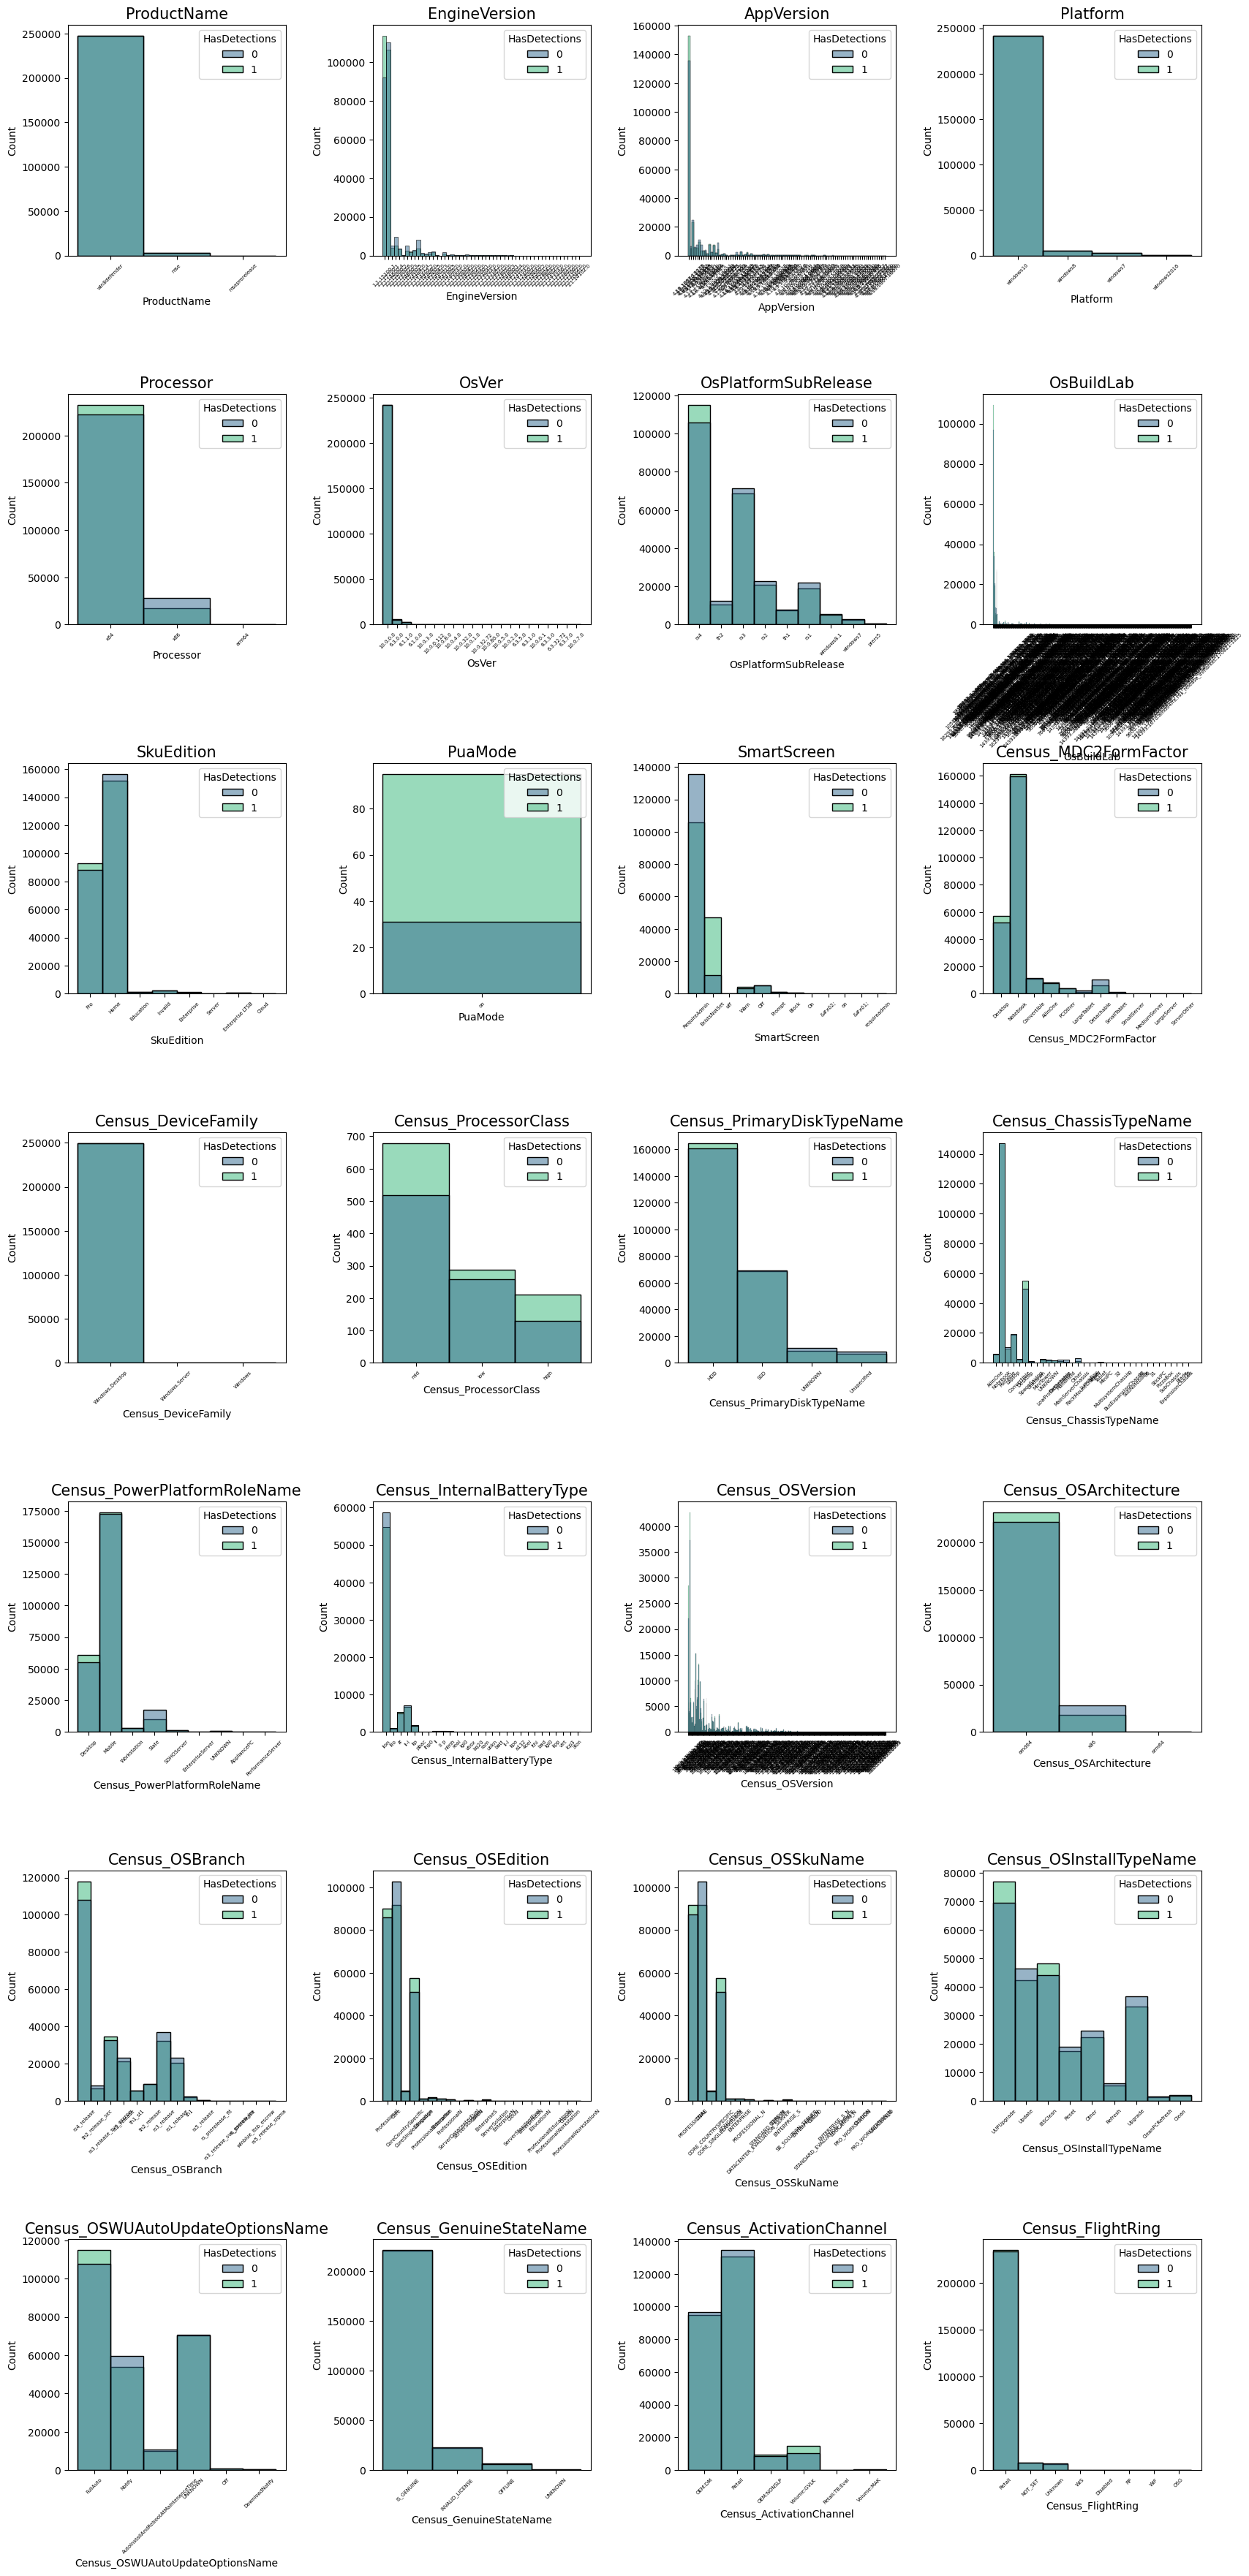

In [16]:
#Filtramos nuestro df para quedarnos con las columnas que tienen datos categoricos + target.
list_labels= ['ProductName', 'EngineVersion', 'AppVersion',
        'Platform', 'Processor', 'OsVer',
       'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'PuaMode',
       'SmartScreen', 'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_ProcessorClass', 'Census_PrimaryDiskTypeName',
       'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
       'Census_InternalBatteryType', 'Census_OSVersion',
       'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition',
       'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing','HasDetections']

df_cat_target= df[list_labels]


plt.figure(figsize=(20, 50))
# Ajuste para reducir el número total de subplots en la visualización
n_cols = 4
n_rows = int(len(df_cat_target.columns) / n_cols) + (len(df_cat_target.columns) % n_cols > 0)

for i, col in enumerate(df_cat_target.columns[:-1]):  # Excluye 'HasDetections' de la visualización
    plt.subplot(n_rows, n_cols, i+1)
    # Usando countplot en lugar de histplot
    sns.histplot(data=df_cat_target, x=col, hue='HasDetections', palette='viridis')
    plt.xticks(rotation=45, fontsize=5)
    plt.title(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()


### 2.3 Distribucion nulos en dataset

In [17]:
# vamos a ver cual es la distribucion de nulos a lo largo de las variabels para ver cuales podemos eliminar (elegir un punto de corte)
nuls= df.isna().sum().sort_values(ascending=False).reset_index()
nuls.columns=['Column','Count of NaN']
nuls['perc_NaN']=(nuls['Count of NaN']/500000)*100
nuls


,Column,Count of NaN,perc_NaN
0,PuaMode,499874,99.97
1,Census_ProcessorClass,497918,99.58
2,DefaultBrowsersIdentifier,475939,95.19
3,Census_IsFlightingInternal,415225,83.05
4,Census_InternalBatteryType,355603,71.12
...,...,...,...
78,ProductName,0,0.00
79,Census_HasOpticalDiskDrive,0,0.00
80,Census_OSVersion,0,0.00
81,Census_OSArchitecture,0,0.00


In [18]:
px.histogram(nuls,x='Column',y='Count of NaN',height=1000)


# aqui ya podemos ver que hay una serie de columnas (10 aprox) que tienen un numero de NA muy elevado asi que las eliminaremos del df más tarde

In [19]:
# identificamos las columnas que tienen mas de un 30% de nulos (o mas de 150.000 NaNs ) para eliminarlas. Recordemos que tenemos 500.000 observaciones
nuls[nuls.perc_NaN >30]

,Column,Count of NaN,perc_NaN
0,PuaMode,499874,99.97
1,Census_ProcessorClass,497918,99.58
2,DefaultBrowsersIdentifier,475939,95.19
3,Census_IsFlightingInternal,415225,83.05
4,Census_InternalBatteryType,355603,71.12
5,Census_ThresholdOptIn,318104,63.62
6,Census_IsWIMBootEnabled,317666,63.53
7,SmartScreen,178596,35.72
8,OrganizationIdentifier,154563,30.91


In [20]:
# Aplicamos el filtro que hemos diseñado para eliminar las columnas con mas del 30% de nulos.
mask= df.isna().sum()<150000

df_filtered= df.loc[:,mask]
df_filtered

# De momento nos hemos desecho de las columnas que tenian un alto porcentaje de nulos. Ahora pasaremos a imputar un valor a dichos nulos(preprocessing)
# Hemos reducido de 83 a 74 las columnas.

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,f1cd864e97bae82bdf96523e1a539121,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1234.0,0,7.00,0,53447.00,1.00,...,355.00,19951.00,0,0.00,0,0,0.00,0.00,11.00,1
1,fd5ba6f5b75325ec0423a6c67cc75942,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1282.0,0,7.00,0,53447.00,1.00,...,486.00,48753.00,0,0.00,0,0,0.00,1.00,3.00,0
2,4e628391e7cc7c482fb3286f486dbd25,win8defender,1.1.15100.1,4.9.10586.1106,1.273.781.0,0,7.00,0,46781.00,2.00,...,554.00,33111.00,1,0.00,1,1,0.00,0.00,15.00,0
3,270a2e9d028144a4df12a9e3da79fba5,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1639.0,0,7.00,0,53447.00,1.00,...,142.00,48473.00,1,0.00,0,0,0.00,0.00,15.00,1
4,06ca8fa8d32c2abdc5b3577d676b3269,win8defender,1.1.15200.1,4.18.1807.18075,1.275.511.0,0,7.00,0,47238.00,2.00,...,355.00,4343.00,1,0.00,1,0,0.00,1.00,13.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,a739cacc292f3f1e745827c1ca6c6ada,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1090.0,0,7.00,0,53447.00,1.00,...,554.00,33088.00,1,0.00,1,0,0.00,1.00,10.00,0
499996,a4c232d528d98343e8f1b73650da7b82,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1620.0,0,7.00,0,53447.00,1.00,...,NaN,NaN,0,0.00,0,0,0.00,0.00,15.00,0
499997,fd16cd542d660848d272e4552bcccb1e,win8defender,1.1.15300.5,4.13.17134.112,1.275.1343.0,0,7.00,0,53447.00,1.00,...,500.00,41727.00,0,0.00,0,0,0.00,0.00,8.00,0
499998,fa0841f8f6147de7c3d287e05270ed42,win8defender,1.1.15100.1,4.14.17639.18041,1.273.483.0,0,7.00,0,43856.00,2.00,...,628.00,11947.00,0,0.00,0,0,0.00,0.00,1.00,0


<a id='seccion3'></a>
## **3. Preprocesamiento**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

El objetivo de este apartado es tratar los datos para que sean aceptables para su modelado. Para esto necesitaremos ausencia de nulos, codificar variables no-numericas y reducir el numero de columnas, ya que con 74columnas + codificacion, el numero de columnas se pueden disparar y eso enlentencera o imposibilitará mucho el procesamiento por parte de nuestro modelo.

Trataremos:
- Tipo de datos
- Tratamiento de nulos
- Correlacion: variable target 
- Reduccion de la dimensionalidad (drop atributos baja varianza o elevada variabilidad o variables altamente correladas entre si)
- Codificacion variables no-numericas

In [21]:
df_filtered.dtypes
# Tenemos tanto datos de tipo numerico (int y float) como tipo string.

MachineIdentifier                           object
ProductName                                 object
EngineVersion                               object
AppVersion                                  object
AvSigVersion                                object
                                            ...   
Census_IsPenCapable                          int64
Census_IsAlwaysOnAlwaysConnectedCapable    float64
Wdft_IsGamer                               float64
Wdft_RegionIdentifier                      float64
HasDetections                                int64
Length: 74, dtype: object

In [22]:
# Echamos un vistazo a las columnas tipo string comprobando que no haya algun valor continuo que deberia ser tipo int o float
df_filtered.select_dtypes(include='object').T
# Comprobamos asi que las columnas tipo string aun pese a tener numeros estan correctas ya que corresponden a valores categoricos.

,0,1,2,3,4,5,6,7,8,9,...,499990,499991,499992,499993,499994,499995,499996,499997,499998,499999
MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5,06ca8fa8d32c2abdc5b3577d676b3269,6c3ff3036d3ecc96729a615653742608,8ab73b7f8dbb0d0d57f54a8b4799e960,1c4ec21828b563afb6b0aa72ef88926d,0b247aa88737776d0f88ce4dee447216,cc9e1141a127a305cddc17baaa36bcb3,...,baecaa76580b2f96e7a319d3521bcdc8,3df610b8bec46c7af0dd50c74756bf7e,1e395f5a138a77514322a1201de81a27,d7f1b593177768d66a2905b09a43a4d5,a687cfd1252ee03ce9658eaf15bdf40e,a739cacc292f3f1e745827c1ca6c6ada,a4c232d528d98343e8f1b73650da7b82,fd16cd542d660848d272e4552bcccb1e,fa0841f8f6147de7c3d287e05270ed42,7b45dc3537e17f16305c5983ca0a1cb9
ProductName,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,...,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender,win8defender
EngineVersion,1.1.15100.1,1.1.15100.1,1.1.15100.1,1.1.15200.1,1.1.15200.1,1.1.15200.1,1.1.15200.1,1.1.15100.1,1.1.15100.1,1.1.15200.1,...,1.1.15200.1,1.1.15100.1,1.1.15200.1,1.1.15100.1,1.1.15200.1,1.1.15200.1,1.1.15100.1,1.1.15300.5,1.1.15100.1,1.1.15100.1
AppVersion,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075,4.18.1807.18075,4.18.1807.18075,4.18.1807.18075,4.18.1806.18062,4.18.1807.18075,4.18.1807.18075,...,4.18.1807.18075,4.18.1806.18062,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075,4.18.1807.18075,4.13.17134.112,4.14.17639.18041,4.18.1807.18075
AvSigVersion,1.273.1234.0,1.273.1282.0,1.273.781.0,1.275.1639.0,1.275.511.0,1.275.981.0,1.275.497.0,1.273.293.0,1.273.418.0,1.275.511.0,...,1.275.1293.0,1.273.520.0,1.275.1665.0,1.273.1420.0,1.275.155.0,1.275.1090.0,1.273.1620.0,1.275.1343.0,1.273.483.0,1.273.1644.0
Platform,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10,...,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10,windows10
Processor,x64,x64,x64,x64,x64,x64,x86,x64,x64,x86,...,x64,x64,x64,x64,x64,x64,x64,x86,x64,x64
OsVer,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,...,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0
OsPlatformSubRelease,rs4,rs4,th2,rs4,rs4,rs3,rs2,rs2,rs4,rs4,...,rs3,rs3,rs4,rs3,th2,rs3,rs3,rs4,rs3,rs4
OsBuildLab,17134.1.amd64fre.rs4_release.180410-1804,17134.1.amd64fre.rs4_release.180410-1804,10586.1176.amd64fre.th2_release_sec.170913-1848,17134.1.amd64fre.rs4_release.180410-1804,17134.1.amd64fre.rs4_release.180410-1804,16299.431.amd64fre.rs3_release_svc_escrow.1805...,15063.0.x86fre.rs2_release.170317-1834,15063.0.amd64fre.rs2_release.170317-1834,17134.1.amd64fre.rs4_release.180410-1804,17134.1.x86fre.rs4_release.180410-1804,...,16299.15.amd64fre.rs3_release.170928-1534,16299.15.amd64fre.rs3_release.170928-1534,17134.1.amd64fre.rs4_release.180410-1804,16299.15.amd64fre.rs3_release.170928-1534,10586.1176.amd64fre.th2_release_sec.170913-1848,16299.431.amd64fre.rs3_release_svc_escrow.1805...,16299.15.amd64fre.rs3_release.170928-1534,17134.1.x86fre.rs4_release.180410-1804,16299.15.amd64fre.rs3_release.170928-1534,17134.1.amd64fre.rs4_release.180410-1804


### **3.1 Imputacion de Nulos**

Como utilizaremos un modelo basado en arboles de decision, imputaremos -1, ya que los outliers no les afecta mucho al resultado y de esta manera si queremos volver a cambiarlo más tarde podemos trackearlo facil.

En otros modelos trataremos estos de distinta manera, los continuos imputaremos mediana de dicha 
columna y los booleanos la moda de su columna. 

Respecto a los datos strings, los nulos de esas columnas los asignaremos a una palabra disntinta, 'UNKNOWN' por ejemplo

Usaremos el SimpleImputer de Scikitlearn

In [23]:
from sklearn.impute import SimpleImputer

# Creamos los imputers para valores numéricos y string con estrategia 'constant' y valor -1 o 'UNKNOWN'respectivamente
numeric_imputer = SimpleImputer(strategy='constant', fill_value=-1)
string_imputer = SimpleImputer(strategy='constant', fill_value='UNKNOWN')

# Imputamos columnas numericas
numeric_cols = df_filtered.select_dtypes(include='number')
df_filtered.loc[:, numeric_cols.columns] = numeric_imputer.fit_transform(numeric_cols)

# Imputamos columnas tipo string
string_cols = df_filtered.select_dtypes(include='object')
df_filtered.loc[:, string_cols.columns] = string_imputer.fit_transform(string_cols)


In [24]:
# Verificamos que ya no hay nulos en el df
df_filtered.isna().sum().sum()

0

In [25]:
# y tampoco duplicados
df_filtered.duplicated().sum()

0

### **3.2 Pearson Correlation: busqueda correlacion con variable target**

Ahora que ya nos hemos asegurado que no hay ni nulos ni duplicados vamos a seguir tratando los datos para ir filtrando las columnas mas importantes.

La estrategia a seguir es quedarnos con las variables que estén mas correlacionadas con la variable target y desechar el resto ya que esto aumenta la complejidad del modelo y la posibilidad del overfiting del modelo.

Tambien eliminar variables altamente correladas entre si (reduccion de la dimensionalidad).


Utilizaremos la Correlacion de Pearson para evaluar si existe correlacion lineal de las variables numericas con el target.


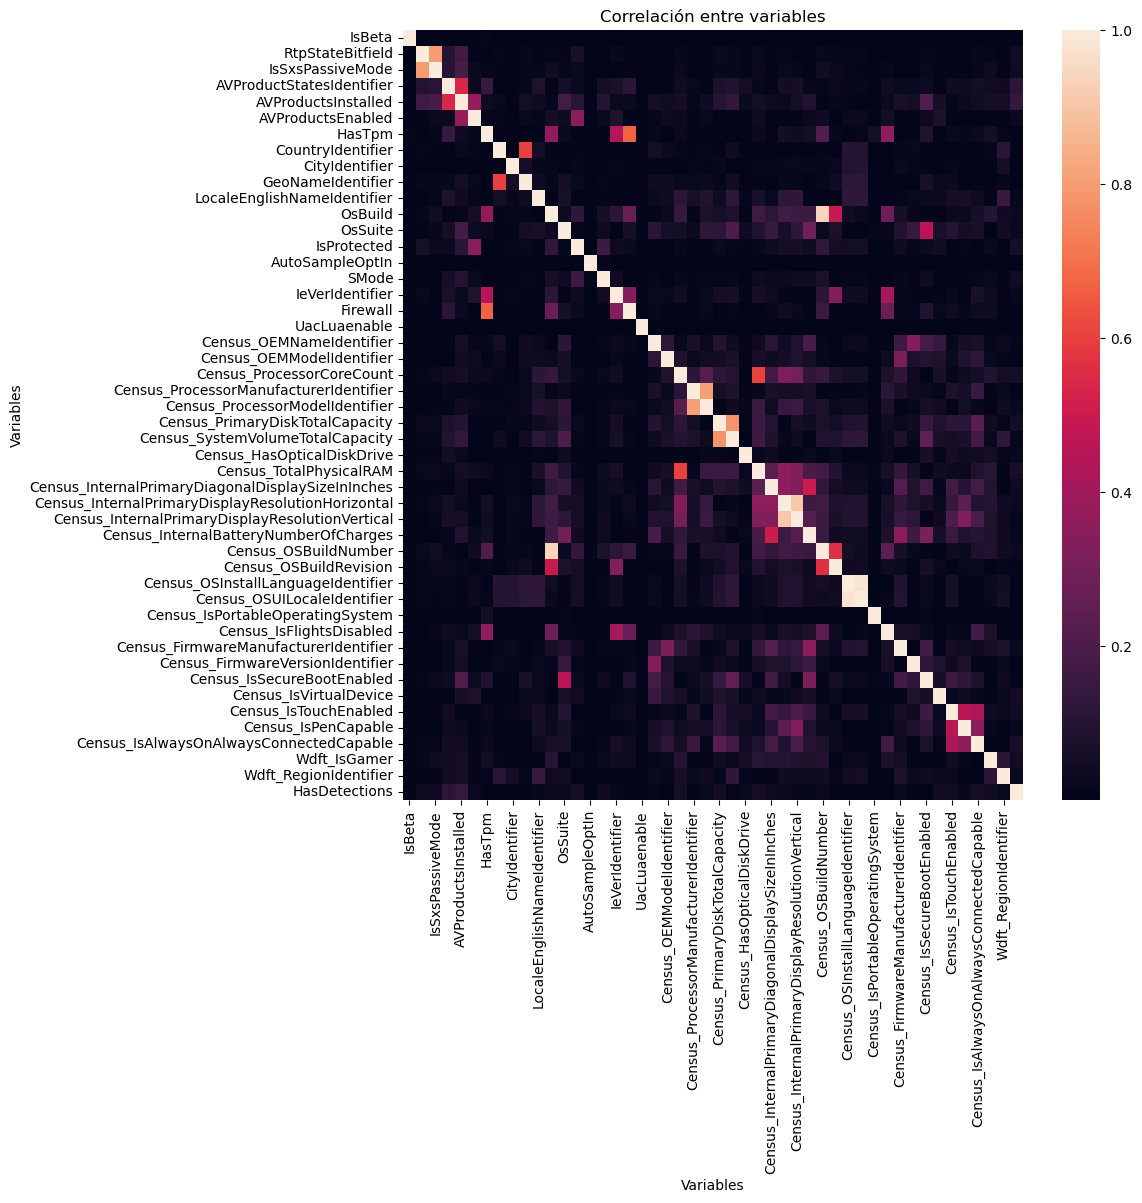

In [26]:

# para hacer la correlacion necesitamos datos numericos. Hacer un OneHotEncoding aqui seria una locura generando una barbaridad de columnas 
# Vamos a visualizar la matriz de correlacion igualmente a través de un heatmap

# Agrupamos variables numericas.
df_num= df_filtered.select_dtypes(include='number')
df_num

# Creamos matriz de correlacion
correlation_matrix = df_num.corr().abs()
# Creamos la figura y el eje
plt.figure(figsize=(10, 10))

# Creamos el heatmap de correlación
sns.heatmap(correlation_matrix)

# Añadimos título y etiquetas de los ejes
plt.title('Correlación entre variables')
plt.xlabel('Variables')
plt.ylabel('Variables')

# Mostramos el heatmap
plt.show()


In [27]:
# visualizamos la correlacion de las variables vs variable target
df_num= df_filtered.select_dtypes(include='number')
pears_corr= df_num.corrwith(df['HasDetections']).drop('HasDetections', errors='ignore').abs().sort_values(ascending=False)
pears_corr

# vemos que la correlacion maxima es de 0.14 en absoluto, muy baja como para entreveer alguna relacion directa.
# vamos a quedarnos con las primeras tres a modo de insight: las variables AVProductsInstalled ,AVProductStatesIdentifier y Census_TotalPhysicalRAM pueden ser importantes.

AVProductsInstalled                                 0.14
AVProductStatesIdentifier                           0.12
Census_TotalPhysicalRAM                             0.06
Census_IsAlwaysOnAlwaysConnectedCapable             0.06
IsProtected                                         0.06
Census_ProcessorCoreCount                           0.05
Census_PrimaryDiskTotalCapacity                     0.05
Census_IsVirtualDevice                              0.05
Wdft_IsGamer                                        0.05
Census_IsTouchEnabled                               0.04
SMode                                               0.04
RtpStateBitfield                                    0.04
IsSxsPassiveMode                                    0.03
Census_InternalPrimaryDiagonalDisplaySizeInInches   0.03
Census_OSBuildNumber                                0.03
Census_InternalPrimaryDisplayResolutionHorizontal   0.03
AVProductsEnabled                                   0.02
OsBuild                        

### **3.3 Phi-k Correlation: correlacion variables numericas y categoricas**

Para este apartado he decidido utilizar la biblioteca Phi-k, que nos va a permitir evaluar la *correlacion no lineal* entre variables tanto numericas como categoricas, a diferencia de las correlaciones mas usuales utilizadas (Pearson), esta biblioteca nos lo permite. Por debajo esta biblioteca agrupa por categorias basadas en cuantiles o rangos y efectua los calculos.


Aqui una breve expliacion de la biblioteca:

La biblioteca Phi_k es una herramienta estadística y de machine learning que se utiliza para calcular la correlación no lineal entre variables, tanto numéricas como categóricas, en un conjunto de datos. A diferencia de las medidas de correlación más tradicionales, como Pearson, que solo pueden capturar relaciones lineales y se aplican únicamente a variables numéricas, Phi_k es capaz de identificar relaciones no lineales y es aplicable a una mezcla de tipos de variables. Esto la hace particularmente valiosa en el análisis exploratorio de datos (EDA) para detectar relaciones entre variables que otras métricas podrían pasar por alto.

Phi_k se basa en el coeficiente de correlación de Matthews (MCC) para calcular la correlación entre pares de variables. El MCC es una medida de la calidad de clasificaciones binarias que puede extenderse a variables categóricas y numéricas mediante la conversión de estas últimas en categorías basadas en cuantiles o rangos. La correlación Phi_k se calcula entonces utilizando una matriz de confusión entre cada par de variables, permitiendo que la medida capte tanto relaciones lineales como no lineales.

Mas informacion: https://phik.readthedocs.io/en/latest/ 

In [28]:
import pandas as pd
import phik
# from phik import resources, report

# Creamos un df para calcular la matriz de correlacion phi_k, eliminamos la variable 'MachineIdentifier' 
# para evitar calculos largos e innecesarios (es unica para cada observacion)
df_phi = df_filtered.drop(labels='MachineIdentifier',axis=1)
df_phi.head()

# Obtenemos la matrix de correlacion por todas las variables
phi_matrix= df_phi.phik_matrix()

# y las correlaciones globales basadas en Phi-K matrix
phi_global= df_phi.global_phik()

interval columns not set, guessing: ['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_IsPortableO

c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\phik\data_quality.py:59: UserWarning:

The number of unique values of variable AvSigVersion is large: 6455. Are you sure this is not an interval variable? Analysis for pairs of variables including AvSigVersion can be slow.



interval columns not set, guessing: ['IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'OsBuild', 'OsSuite', 'IsProtected', 'AutoSampleOptIn', 'SMode', 'IeVerIdentifier', 'Firewall', 'UacLuaenable', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_InternalPrimaryDisplayResolutionVertical', 'Census_InternalBatteryNumberOfCharges', 'Census_OSBuildNumber', 'Census_OSBuildRevision', 'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier', 'Census_IsPortableO

c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\phik\data_quality.py:59: UserWarning:

The number of unique values of variable AvSigVersion is large: 6455. Are you sure this is not an interval variable? Analysis for pairs of variables including AvSigVersion can be slow.

c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\phik\phik.py:319: RuntimeWarning:

invalid value encountered in sqrt



In [29]:
# y generamos la matriz de correlacion entre variables
phi_matrix

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
ProductName,1.00,0.03,0.68,0.00,1.00,0.00,0.01,0.69,0.04,0.11,...,0.07,0.05,0.06,0.01,0.02,0.01,0.06,0.16,0.07,0.00
EngineVersion,0.03,1.00,0.77,1.00,0.00,0.06,0.02,0.33,0.14,0.06,...,0.06,0.05,0.07,0.08,0.02,0.02,0.07,0.34,0.22,0.15
AppVersion,0.68,0.77,1.00,0.93,0.00,0.14,0.06,0.52,0.25,0.25,...,0.11,0.11,0.15,0.10,0.06,0.05,0.19,0.40,0.27,0.13
AvSigVersion,0.00,1.00,0.93,1.00,0.00,0.11,0.00,0.45,0.35,0.25,...,0.10,0.09,0.09,0.00,0.04,0.00,0.00,0.42,0.47,0.18
IsBeta,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Census_IsPenCapable,0.01,0.02,0.05,0.00,0.00,0.01,0.00,0.05,0.04,0.01,...,0.55,0.18,0.19,0.02,0.66,1.00,0.23,0.01,0.09,0.03
Census_IsAlwaysOnAlwaysConnectedCapable,0.06,0.07,0.19,0.00,0.00,0.02,0.01,0.10,0.14,0.05,...,0.49,0.28,0.04,0.07,0.28,0.23,1.00,0.20,0.11,0.04
Wdft_IsGamer,0.16,0.34,0.40,0.42,0.00,0.02,0.02,0.14,0.16,0.06,...,0.15,0.08,0.03,0.32,0.04,0.01,0.20,1.00,0.81,0.03
Wdft_RegionIdentifier,0.07,0.22,0.27,0.47,0.00,0.03,0.05,0.27,0.11,0.07,...,0.23,0.19,0.16,0.18,0.11,0.09,0.11,0.81,1.00,0.05


<Axes: >

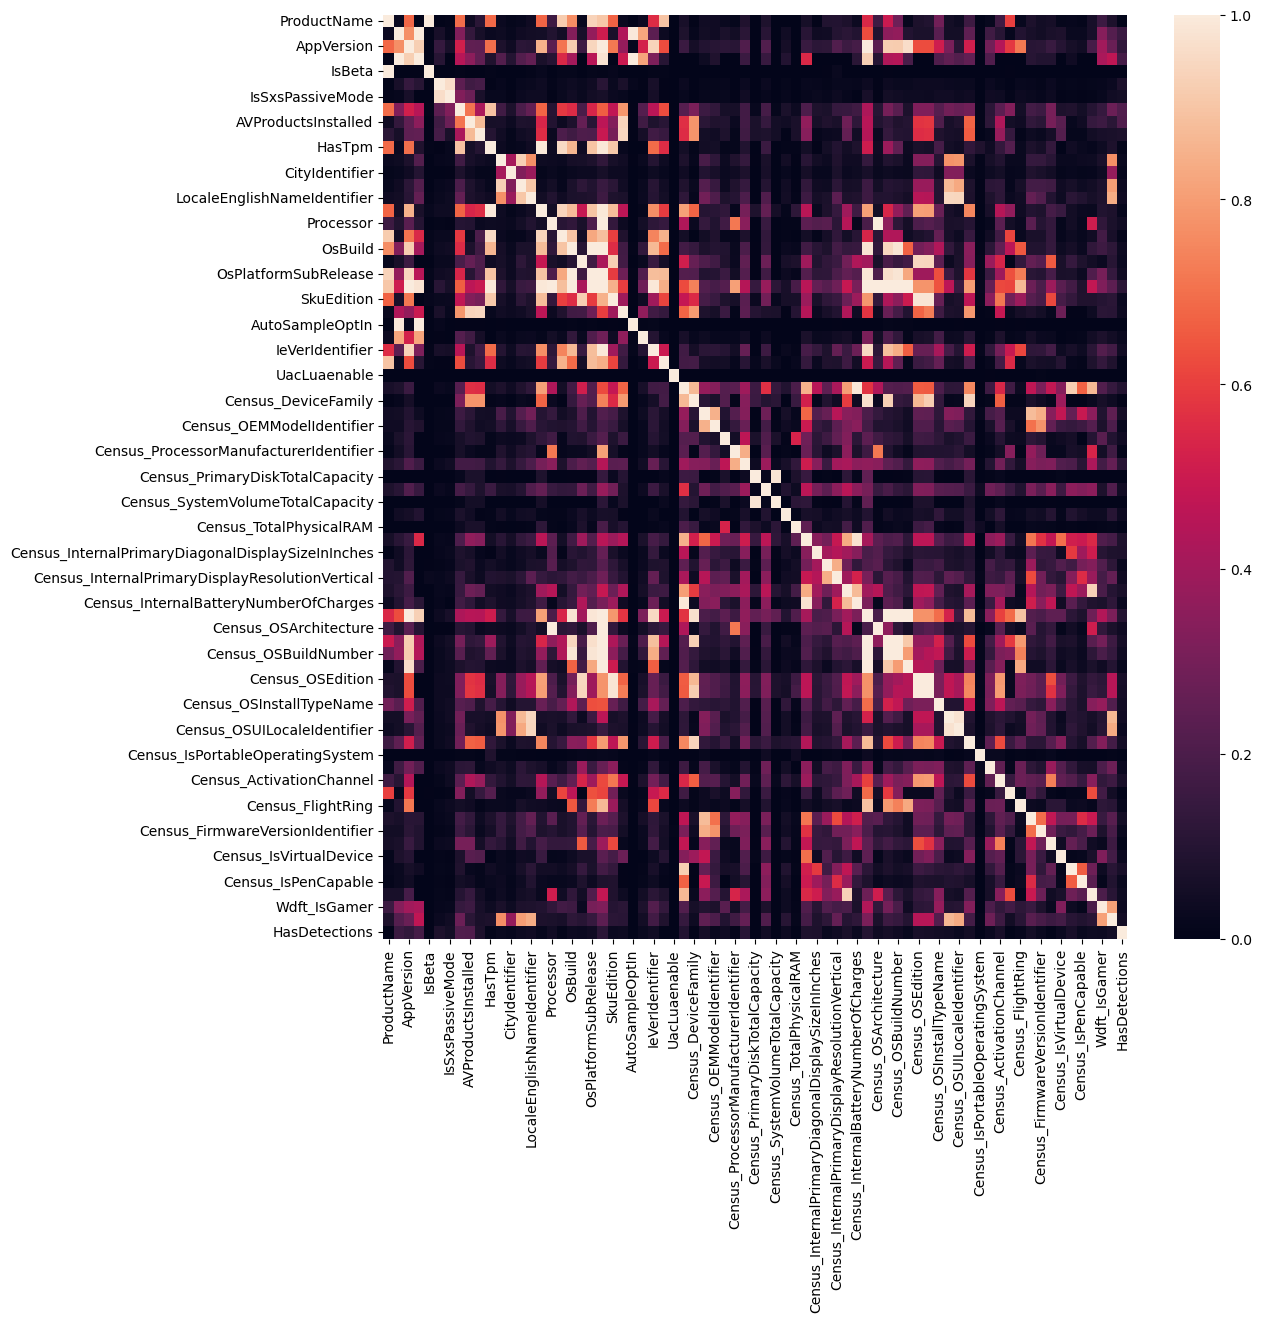

In [30]:
# creamos un heatmap para visualizar los datos de las correlaciones. En contraste con la correlacion de Pearson, si vemos que Phi-K si identifica mas correlaciones
# entre variables ( con bastante alta correlacion)
plt.figure(figsize=(12,12))
sns.heatmap(phi_matrix)

In [31]:
# vamos a extraer las variables que mas correlacionadas estan con el target segun phik

phik_corr= phi_matrix['HasDetections'].abs().sort_values(ascending=False)
phik_corr.head(10)

HasDetections                     1.00
AVProductStatesIdentifier         0.21
AVProductsInstalled               0.21
AvSigVersion                      0.18
EngineVersion                     0.15
AppVersion                        0.13
OsBuildLab                        0.11
Census_ProcessorModelIdentifier   0.11
Census_OSVersion                  0.09
Census_MDC2FormFactor             0.09
Name: HasDetections, dtype: float64

In [32]:
# y comparamos con las que si estaban correladas en pearson
pears_corr.head(10)

# hay algunas que si conciden en ambas correlaciones(AVProductStatesIdentifier , AVProductsInstalled) y otras que no (Census_TotalPhysicalRAM, Census_InternalPrimaryDiagonalDisplaySizeInInches...)
# tambien podemos ver que Phik consigue extraer mayor correlacion de dichas variables comunes.


AVProductsInstalled                       0.14
AVProductStatesIdentifier                 0.12
Census_TotalPhysicalRAM                   0.06
Census_IsAlwaysOnAlwaysConnectedCapable   0.06
IsProtected                               0.06
Census_ProcessorCoreCount                 0.05
Census_PrimaryDiskTotalCapacity           0.05
Census_IsVirtualDevice                    0.05
Wdft_IsGamer                              0.05
Census_IsTouchEnabled                     0.04
dtype: float64

In [33]:
# guardaremos las 10 primeras de cada una para extraer features importantes para nuestro primer modelo.

feature_extr= list(phik_corr.head(10).index.union(pears_corr.head(10).index))
feature_extr

['AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AppVersion',
 'AvSigVersion',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsTouchEnabled',
 'Census_IsVirtualDevice',
 'Census_MDC2FormFactor',
 'Census_OSVersion',
 'Census_PrimaryDiskTotalCapacity',
 'Census_ProcessorCoreCount',
 'Census_ProcessorModelIdentifier',
 'Census_TotalPhysicalRAM',
 'EngineVersion',
 'HasDetections',
 'IsProtected',
 'OsBuildLab',
 'Wdft_IsGamer']

### 3.4 Eliminacion Variables Altamente Correladas entre si(Dimensionality reduction)

Utilizando las matrices de correlacion de Phik vamos a eliminar las variables que estén mas correladas entre sí para así ir reduciendo el numero de columnas que ingresaremos al modelo. De esta forma el modelo tendrá menos ''ruido de fondo'' y podrá clasificar mejor


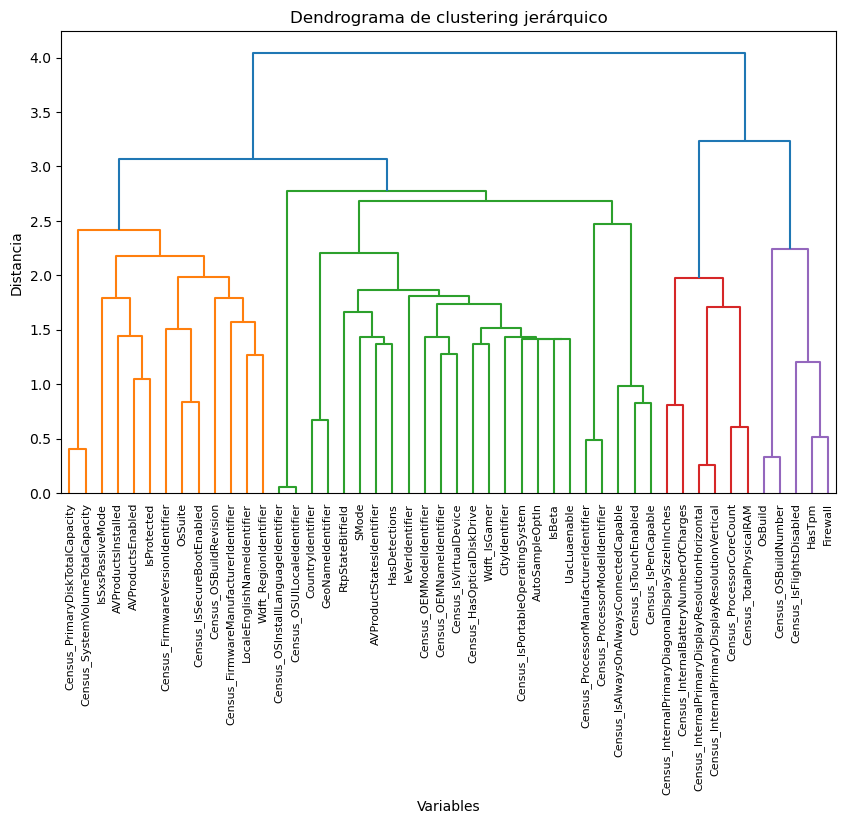

In [34]:
from scipy.cluster import hierarchy

df_num= df_filtered.select_dtypes(include='number')
df_num

# Creamos matriz de correlacion
correlation_matrix = df_num.corr()


# Aplicar clustering jerárquico a la matriz de correlación
clusters = hierarchy.linkage(correlation_matrix, method='ward')



# Dibujar el dendrograma para visualizar los clusters
plt.figure(figsize=(10, 6))
dn = hierarchy.dendrogram(clusters, labels=correlation_matrix.columns, leaf_rotation=90)
plt.title('Dendrograma de clustering jerárquico')
plt.xlabel('Variables')
plt.ylabel('Distancia')
plt.show()


In [35]:
# La idea es extraer una lista de las features mas correlacionadas entre si para luego condensarlas en nuestro df original

# filtrar las CORRELACIONES MAYORES A 0.5 y distintas de 1 en la matrix de Phik
filtered_correlation = phi_matrix.abs()[(phi_matrix.abs() > 0.5) & (phi_matrix.abs() != 1)]

# incluimos tambien la columna de correlaciones con la variable target 'HasDetections' para poder comparar más tarde
filtered_correlation['HasDetections']= phi_matrix['HasDetections']


# Eliminar las filas y columnas que contienen todos los valores nulos
filtered_correlation = filtered_correlation.dropna(axis=0, how='all')
filtered_correlation = filtered_correlation.dropna(axis=1, how='all')
# Obtenemos matriz
filtered_correlation


,ProductName,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
ProductName,NaN,NaN,0.68,NaN,NaN,NaN,0.69,NaN,NaN,0.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
EngineVersion,NaN,NaN,0.77,1.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15
AppVersion,0.68,0.77,NaN,0.93,NaN,NaN,0.52,NaN,NaN,0.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13
AvSigVersion,NaN,1.00,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18
IsBeta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Census_IsPenCapable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.55,NaN,NaN,NaN,0.66,NaN,NaN,NaN,NaN,0.03
Census_IsAlwaysOnAlwaysConnectedCapable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04
Wdft_IsGamer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.81,0.03
Wdft_RegionIdentifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.81,NaN,0.05


In [36]:
# Extraemos las features mas correladas

'''
Documentacion: Aqui lo que estamos tratando de hacer es crear un nuevo dataframe
donde poder comparar de las dos variables altamente correladas, cual es la que menos correlacion
tiene con el target, para esta forma eliminarla más tarde.
La idea es tener 5 columnas, donde almacene pares de variables correladas y su correlacion con el target y finalmente la correlacion entre ellas

'''

correlation_dict = {'variable_1': [], 'variable_2': [], 'value_corr_features': []}

# Recorrer las filas y columnas de la matriz de correlación filtrada
for column in filtered_correlation.columns:
    for index, value in filtered_correlation[column].items():
        # Verificar si el valor no es nulo
        if not pd.isnull(value):
            # Almacenar los valores en el diccionario
            correlation_dict['variable_1'].append(column)
        
            correlation_dict['variable_2'].append(index)
            # almacenamos el valor de correlacion del valor de variable_2 con respecto al target('HasDetections')
           
            correlation_dict['value_corr_features'].append(value)

# Convertir el diccionario en un DataFrame
correlation_df = pd.DataFrame(correlation_dict)
correlation_df = correlation_df.drop_duplicates(subset='value_corr_features')
# Create a new column to store the correlation value of variable_1 with respect to the target
correlation_df['corr_target_variable_1'] = 0
correlation_df['corr_target_variable_2'] = 0

# Iterate through the pairs of values
for i, v in filtered_correlation['HasDetections'].items():
    # Get the index of the corresponding variable_1 value
    index = correlation_df[correlation_df['variable_1'] == i].index
    
    # Update the correlation value in the new column
    correlation_df.loc[index, 'corr_target_variable_1'] = v

# Iterate through the pairs of values
for x, y in filtered_correlation['HasDetections'].items():
    # Get the index of the corresponding variable_1 value
    index = correlation_df[correlation_df['variable_2'] == x].index
    
    # Update the correlation value in the new column
    correlation_df.loc[index, 'corr_target_variable_2'] = y

# Eliminamos observaciones donde el valor de corr_target es igual a 1

correlation_df = correlation_df[correlation_df['corr_target_variable_1'] != 1]

# Reordenamos columnas
correlation_df = correlation_df[['variable_1', 'corr_target_variable_1','variable_2', 'corr_target_variable_2','value_corr_features']]

correlation_df= correlation_df.sort_values(by='value_corr_features',ascending=False)    
correlation_df

,variable_1,corr_target_variable_1,variable_2,corr_target_variable_2,value_corr_features
128,Processor,0.04,Census_OSArchitecture,0.04,1.00
197,OsBuildLab,0.11,Census_OSArchitecture,0.04,1.00
196,OsBuildLab,0.11,Census_OSVersion,0.09,1.00
361,Census_OSVersion,0.09,Census_OSBranch,0.06,1.00
14,EngineVersion,0.15,AvSigVersion,0.18,1.00
...,...,...,...,...,...
312,Census_ProcessorModelIdentifier,0.11,Census_ChassisTypeName,0.08,0.51
15,EngineVersion,0.15,OsBuildLab,0.11,0.51
395,Census_OSBuildNumber,0.04,Census_OSWUAutoUpdateOptionsName,0.05,0.50
330,Census_InternalPrimaryDiagonalDisplaySizeInInches,0.08,Census_IsAlwaysOnAlwaysConnectedCapable,0.04,0.50


In [37]:

# creamos una nueva columna que visualice el valor de la variable_1 o variable_2  menos correlada de las dos con el target

correlation_df['variable_less_corr_target_value'] = correlation_df.apply(lambda x: x['variable_1'] if x['corr_target_variable_1'] < x['corr_target_variable_2'] else x['variable_2'], axis=1)

correlation_df

,variable_1,corr_target_variable_1,variable_2,corr_target_variable_2,value_corr_features,variable_less_corr_target_value
128,Processor,0.04,Census_OSArchitecture,0.04,1.00,Census_OSArchitecture
197,OsBuildLab,0.11,Census_OSArchitecture,0.04,1.00,Census_OSArchitecture
196,OsBuildLab,0.11,Census_OSVersion,0.09,1.00,Census_OSVersion
361,Census_OSVersion,0.09,Census_OSBranch,0.06,1.00,Census_OSBranch
14,EngineVersion,0.15,AvSigVersion,0.18,1.00,EngineVersion
...,...,...,...,...,...,...
312,Census_ProcessorModelIdentifier,0.11,Census_ChassisTypeName,0.08,0.51,Census_ChassisTypeName
15,EngineVersion,0.15,OsBuildLab,0.11,0.51,OsBuildLab
395,Census_OSBuildNumber,0.04,Census_OSWUAutoUpdateOptionsName,0.05,0.50,Census_OSBuildNumber
330,Census_InternalPrimaryDiagonalDisplaySizeInInches,0.08,Census_IsAlwaysOnAlwaysConnectedCapable,0.04,0.50,Census_IsAlwaysOnAlwaysConnectedCapable


In [38]:
# Elegimos las variables menos correladas con el target para eliminarlas del df, nuestro punto de corte es que tengan mayor de 0.8 de correlacion entre si.

drop_list= list(correlation_df[correlation_df.value_corr_features>0.8].variable_less_corr_target_value.unique())
print('Variables a eliminar: ',len(drop_list))
display(drop_list)

# conseguimos de esta forma eliminar 44 variables potencialmente no importantes y recurrentes.

Variables a eliminar:  44


['Census_OSArchitecture',
 'Census_OSVersion',
 'Census_OSBranch',
 'EngineVersion',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'OsBuildLab',
 'Census_OSSkuName',
 'HasTpm',
 'AutoSampleOptIn',
 'Platform',
 'Census_InternalBatteryNumberOfCharges',
 'IeVerIdentifier',
 'OsPlatformSubRelease',
 'SkuEdition',
 'OsBuild',
 'Census_SystemVolumeTotalCapacity',
 'Census_OSUILocaleIdentifier',
 'Census_DeviceFamily',
 'IsSxsPassiveMode',
 'OsVer',
 'LocaleEnglishNameIdentifier',
 'IsProtected',
 'OsSuite',
 'ProductName',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'CountryIdentifier',
 'Census_IsTouchEnabled',
 'AppVersion',
 'GeoNameIdentifier',
 'Firewall',
 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'AVProductsEnabled',
 'Census_OSInstallLanguageIdentifier',
 'Census_ChassisTypeName',
 'Census_OEMModelIdentifier',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_FirmwareVersionIdentifier',
 'Census_Processo

In [39]:

for i in feature_extr:
    # verificamos si alguna de nuestros elementos de la lista esta contenida dentro de otra
    if i in drop_list:
        print(i)
        # y eliminamos esas variables valiosas de las que queremos eliminar.
        drop_list.remove(i)

display(drop_list)

AppVersion
Census_IsAlwaysOnAlwaysConnectedCapable
Census_IsTouchEnabled
Census_OSVersion
EngineVersion
IsProtected
OsBuildLab
Wdft_IsGamer


['Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSSkuName',
 'HasTpm',
 'AutoSampleOptIn',
 'Platform',
 'Census_InternalBatteryNumberOfCharges',
 'IeVerIdentifier',
 'OsPlatformSubRelease',
 'SkuEdition',
 'OsBuild',
 'Census_SystemVolumeTotalCapacity',
 'Census_OSUILocaleIdentifier',
 'Census_DeviceFamily',
 'IsSxsPassiveMode',
 'OsVer',
 'LocaleEnglishNameIdentifier',
 'OsSuite',
 'ProductName',
 'CountryIdentifier',
 'GeoNameIdentifier',
 'Firewall',
 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'AVProductsEnabled',
 'Census_OSInstallLanguageIdentifier',
 'Census_ChassisTypeName',
 'Census_OEMModelIdentifier',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_FirmwareVersionIdentifier',
 'Census_ProcessorManufacturerIdentifier',
 'Census_PowerPlatformRoleName',
 'SMode']

In [40]:
# eliminamos de nuestro df.
df_filtered.drop(labels=drop_list,axis=1,inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16712\4095403210.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 3.4 Eliminacion Variables constantes/alta variabilidad

Necesitamos eliminar variables que no aporten al modelo, esto se traduce que valores que nunca se repiten o que no cambian en toda la columna podremos eliminarlos al considerarlo constante y valor unico respectivamente. Esto al modelo no lo ayuda en su procesamiento asi que lo eliminaremos

In [41]:
# trabajaremos separadamente variables categoricas y numericas
df_cat= df_filtered.select_dtypes(exclude='number')
df_cat

# vamos a intentar ver cuanta variabilidad de categorias hay por cada columna categorica, 
# esto nos será util para hacernos una idea de si los valores se repiten mucho o no.

lista_var = []

# visualizamos cuantos registros distintos por cada columna
for col in df_cat.columns:
    # Utiliza value_counts para obtener la cantidad de valores únicos en cada columna
    unique_values_count = df_cat[col].value_counts().shape[0]
    
    # Añade la cantidad de valores únicos a la lista
    lista_var.append(unique_values_count)
lista_var


[500000, 53, 95, 6455, 3, 454, 12, 4, 305, 22, 9, 4, 6]

In [42]:
# Me preocupa que cuando vaya a hacer un OHE con las variables categoricas se me dispare el numero de columnas.
# vamos a crear un df donde almacenaremos los porcentajes por representacion de clase, poniendo un limite de 6 clases distintas.

# Creamos una lista para ir almacenando losresultados que qeremos plasmar en el df
resultados = []

# Iterar sobre las columnas del DataFrame
for col in df_cat.columns:
    # Calcular las frecuencias y los porcentajes
    frecuencias = df_cat[col].value_counts()
    porcentajes = frecuencias / len(df_cat)
    
    # Almacenar los nombres de las columnas y los 6 primeros porcentajes
    resultados.append([col] + list(porcentajes.head(6)))

df_perc_class = pd.DataFrame(resultados, columns=['Columna', 'Clase_1', 'Clase_2', 'Clase_3', 'Clase_4', 'Clase_5', 'Clase_6'])
df_perc_class.sort_values(by='Clase_1',ascending=False)


,Columna,Clase_1,Clase_2,Clase_3,Clase_4,Clase_5,Clase_6
4,Processor,0.91,0.09,0.00,NaN,NaN,NaN
11,Census_GenuineStateName,0.88,0.09,0.03,0.00,NaN,NaN
7,Census_PrimaryDiskTypeName,0.65,0.28,0.04,0.03,NaN,NaN
6,Census_MDC2FormFactor,0.64,0.22,0.04,0.03,0.03,0.02
2,AppVersion,0.58,0.10,0.04,0.03,0.03,0.03
12,Census_ActivationChannel,0.53,0.38,0.05,0.04,0.00,0.00
1,EngineVersion,0.43,0.41,0.03,0.02,0.02,0.02
5,OsBuildLab,0.41,0.14,0.11,0.08,0.03,0.03
9,Census_OSEdition,0.39,0.35,0.22,0.02,0.01,0.00
10,Census_OSInstallTypeName,0.29,0.18,0.18,0.14,0.09,0.07


In [43]:
# En la df de arriba podemos ver la distribucion porcentual de las clases segun las distintas variables categoricas.

# Esto nos va a servir para filtrar aun mas las columnas, y reducir dimensionalidad pensando en el OHE. Las columnas donde las clases o son 99% de una clase o hay mucha 
# fragmentacion y (0.000001% de cada clase, ej: MachineIdentifier), no aportarán nada de valor al modelo asi que las eliminaremos.

# Nos interesará quedarnos con las variables que tengan cierta fragmentacion que pueda suponer un cambio sifgnificativo respecto a la variable target del modelo, por ejemplo,
# si AppVersion que es la version del antivirus (0.5776	0.0953	0.0404	0.0306	0.0288	0.0264)

col_drop_list= df_perc_class.query('Clase_1 >0.9 or Clase_1 <0.1 ')['Columna'].to_list()

# Aqui ya obtenemos los nombres de columnas que vamos a eliminar, hemos aplicado que tiene que haber menos de un 90% de dominancia de clase o mas de 10% de dominancia de clase.
# mas tarde si queremos podemos reajustar este filtro y eliminar más o menos columnas.

# resulta que hay un parametro en OHE que puede gestionar tanto el numero maximo de clases en una variable como la minima frecuencia. Lo veremos mas tarde (max_categories)

col_drop_list
# visualizamos las columnas categoricas que eliminaremos.

['MachineIdentifier', 'AvSigVersion', 'Processor']

In [44]:
# hacemos lo lo mismo pero para las numericas (solo de caracter informativo...ya meteremos mano si queremos eliminar más columnas)
resultados = []

df_num= df_filtered.select_dtypes(include='number')
# Iterar sobre las columnas del DataFrame
for col in df_num.columns:
    # Calcular las frecuencias y los porcentajes
    frecuencias = df_num[col].value_counts()
    porcentajes = frecuencias / len(df_num)
    
    # Almacenar los nombres de las columnas y los 6 primeros porcentajes
    resultados.append([col] + list(porcentajes.head(6)))

# Crear un DataFrame con los resultados
df_perc_class_num = pd.DataFrame(resultados, columns=['Columna', 'Clase_1', 'Clase_2', 'Clase_3', 'Clase_4', 'Clase_5', 'Clase_6'])

# Mostrar el DataFrame de resultados
df_perc_class_num.sort_values(by='Clase_1',ascending=False)

,Columna,Clase_1,Clase_2,Clase_3,Clase_4,Clase_5,Clase_6
0,IsBeta,1.00,0.00,NaN,NaN,NaN,NaN
15,Census_IsPortableOperatingSystem,1.00,0.00,NaN,NaN,NaN,NaN
6,UacLuaenable,0.99,0.01,0.00,0.00,0.00,0.00
18,Census_IsVirtualDevice,0.99,0.01,0.00,NaN,NaN,NaN
16,Census_IsFlightsDisabled,0.98,0.02,0.00,NaN,NaN,NaN
1,RtpStateBitfield,0.97,0.02,0.00,0.00,0.00,0.00
20,Census_IsPenCapable,0.96,0.04,NaN,NaN,NaN,NaN
5,IsProtected,0.94,0.05,0.00,NaN,NaN,NaN
21,Census_IsAlwaysOnAlwaysConnectedCapable,0.94,0.06,0.01,NaN,NaN,NaN
11,Census_HasOpticalDiskDrive,0.92,0.08,NaN,NaN,NaN,NaN


In [45]:
# En la df de arriba podemos ver la distribucion porcentual de las clases segun las distintas variables numericas

col_drop_list_num= df_perc_class_num.query('Clase_1 >0.9 or Clase_1 <0.1 ')['Columna'].to_list()

# Aqui ya obtenemos los nombres de columnas que vamos a eliminar, hemos aplicado que tiene que haber menos de un 90% de dominancia de clase o mas de 10% de dominancia de clase.
# mas tarde si queremos podemos reajustar este filtro y eliminar más o menos columnas.

col_drop_list_num
# visualizamos las columna numericas que eliminaremos.

['IsBeta',
 'RtpStateBitfield',
 'CityIdentifier',
 'IsProtected',
 'UacLuaenable',
 'Census_ProcessorModelIdentifier',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsVirtualDevice',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable']

In [46]:
# juntamos toto en una misma lista de variables a eliminar
drop_list_final= col_drop_list+col_drop_list_num+drop_list

# eliminamos las variables valiosas
for i in feature_extr:
    # verificamos si alguna de nuestros elementos de la lista esta contenida dentro de otra
    if i in drop_list_final:
        print(i)
        drop_list_final.remove(i)

display(drop_list_final)


AvSigVersion
Census_IsAlwaysOnAlwaysConnectedCapable
Census_IsVirtualDevice
Census_ProcessorModelIdentifier
IsProtected


['MachineIdentifier',
 'Processor',
 'IsBeta',
 'RtpStateBitfield',
 'CityIdentifier',
 'UacLuaenable',
 'Census_HasOpticalDiskDrive',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSSkuName',
 'HasTpm',
 'AutoSampleOptIn',
 'Platform',
 'Census_InternalBatteryNumberOfCharges',
 'IeVerIdentifier',
 'OsPlatformSubRelease',
 'SkuEdition',
 'OsBuild',
 'Census_SystemVolumeTotalCapacity',
 'Census_OSUILocaleIdentifier',
 'Census_DeviceFamily',
 'IsSxsPassiveMode',
 'OsVer',
 'LocaleEnglishNameIdentifier',
 'OsSuite',
 'ProductName',
 'CountryIdentifier',
 'GeoNameIdentifier',
 'Firewall',
 'Census_FlightRing',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OSWUAutoUpdateOptionsName',
 'AVProductsEnabled',
 'Census_OSInstallLanguageIdentifier',
 'Census_ChassisTypeName',
 'Census_OEMModelIdentifier',
 'Census_InternalPrimaryDisplayResolut

In [47]:
# y eliminamos las variables poco importantes del df 

df_filtered.drop(labels=[i for i in df_filtered.columns if i in drop_list_final] ,axis=1,inplace=True)
df_filtered

C:\Users\Usuario\AppData\Local\Temp\ipykernel_16712\348631685.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,OsBuildLab,IsProtected,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_ProcessorCoreCount,...,Census_OSInstallTypeName,Census_GenuineStateName,Census_ActivationChannel,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,1.1.15100.1,4.18.1807.18075,1.273.1234.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Desktop,1443.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,0.00,11.00,1
1,1.1.15100.1,4.18.1807.18075,1.273.1282.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,2102.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,1.00,3.00,0
2,1.1.15100.1,4.9.10586.1106,1.273.781.0,46781.00,2.00,10586.1176.amd64fre.th2_release_sec.170913-1848,1.00,Convertible,2206.00,4.00,...,Update,IS_GENUINE,Retail,1,0.00,1,0.00,0.00,15.00,0
3,1.1.15200.1,4.18.1807.18075,1.275.1639.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,525.00,8.00,...,IBSClean,IS_GENUINE,Retail,1,0.00,0,0.00,0.00,15.00,1
4,1.1.15200.1,4.18.1807.18075,1.275.511.0,47238.00,2.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,1443.00,4.00,...,Update,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,13.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.1.15200.1,4.18.1807.18075,1.275.1090.0,53447.00,1.00,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.00,Convertible,2102.00,4.00,...,Upgrade,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,10.00,0
499996,1.1.15100.1,4.18.1807.18075,1.273.1620.0,53447.00,1.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,666.00,4.00,...,Upgrade,INVALID_LICENSE,Retail,0,0.00,0,0.00,0.00,15.00,0
499997,1.1.15300.5,4.13.17134.112,1.275.1343.0,53447.00,1.00,17134.1.x86fre.rs4_release.180410-1804,1.00,Desktop,2206.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,8.00,0
499998,1.1.15100.1,4.14.17639.18041,1.273.483.0,43856.00,2.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,2668.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,1.00,0


In [48]:
# Con el OneHotEncoder de la biblioteca de scikit-learn podemos filtrar las categorias maximas y frecuencias minimas con los argumentso 'max_categories'
# y 'min_frequency' pero no me permite aplicar mi filtro de 90/10 % comentado antes.

columns_to_keep = []
for column in df_filtered.columns:
    # Si la columna está en la lista de características a conservar, añádela directamente
    if column in feature_extr:
        columns_to_keep.append(column)
    else:
        # Calcula la frecuencia relativa de la clase más común
        max_freq = df_filtered[column].value_counts(normalize=True).max()

        # Conservar la columna si ninguna clase domina más del 90% ni menos del 10%
        if 0.1 < max_freq < 0.9:
            columns_to_keep.append(column)

# Ahora df_filtered contiene solo las columnas que cumplen con tu criterio de dominancia de clase y las características en 'feature_extr'
df_filtered = df_filtered[columns_to_keep]
df_filtered


# hemos conseguido reducir las columnas de 83 a 28

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,OsBuildLab,IsProtected,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_ProcessorCoreCount,...,Census_OSInstallTypeName,Census_GenuineStateName,Census_ActivationChannel,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,1.1.15100.1,4.18.1807.18075,1.273.1234.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Desktop,1443.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,0.00,11.00,1
1,1.1.15100.1,4.18.1807.18075,1.273.1282.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,2102.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,1.00,3.00,0
2,1.1.15100.1,4.9.10586.1106,1.273.781.0,46781.00,2.00,10586.1176.amd64fre.th2_release_sec.170913-1848,1.00,Convertible,2206.00,4.00,...,Update,IS_GENUINE,Retail,1,0.00,1,0.00,0.00,15.00,0
3,1.1.15200.1,4.18.1807.18075,1.275.1639.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,525.00,8.00,...,IBSClean,IS_GENUINE,Retail,1,0.00,0,0.00,0.00,15.00,1
4,1.1.15200.1,4.18.1807.18075,1.275.511.0,47238.00,2.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,1443.00,4.00,...,Update,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,13.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.1.15200.1,4.18.1807.18075,1.275.1090.0,53447.00,1.00,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.00,Convertible,2102.00,4.00,...,Upgrade,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,10.00,0
499996,1.1.15100.1,4.18.1807.18075,1.273.1620.0,53447.00,1.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,666.00,4.00,...,Upgrade,INVALID_LICENSE,Retail,0,0.00,0,0.00,0.00,15.00,0
499997,1.1.15300.5,4.13.17134.112,1.275.1343.0,53447.00,1.00,17134.1.x86fre.rs4_release.180410-1804,1.00,Desktop,2206.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,8.00,0
499998,1.1.15100.1,4.14.17639.18041,1.273.483.0,43856.00,2.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,2668.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,1.00,0


In [49]:
# guardamos el df en un csv para utilizarlo posteriormente.
df_filtered.to_csv('df_filtered.csv',index=False)

### 3.5 Encoding: One Hot Encoding


Realizamos One Hot Encoding para transformar variables categóricas en un formato que los modelos de aprendizaje automático puedan interpretar ya que los algoritmos no aceptan datos que no sean numericos. El One Hot Encoding permite incorporar la información categórica en el modelo al convertir cada categoría en una columna nueva y asignar valores binarios (0 o 1) dependiendo de la presencia de la categoría. 
Esto nos mejora la capacidad del modelo para aprender patrones específicos asociados a las variables categoricas.

In [50]:
# separamos el df en varibales numericas y categoricas.
df_cat= df_filtered.select_dtypes(exclude='number')
df_num= df_filtered.select_dtypes(include='number')

In [51]:
# Hemos decidido utilizar el OHE en lugar del get_dummies() de pandas porque me parece mas flexible en sus parametros. Ademas otro tipo de encoding no seria aplicable.

from sklearn.preprocessing import OneHotEncoder


# (sparse=False) en caso de querer matriz densa(guarda 0s). El valor por defecto (True) se recomienda cuando los datos son muy grandes.
# fijamos en 12 las categorias maximas por clase con el objetivo de limitar el numero de columnas (aumento dimensionalidad)
encoder = OneHotEncoder(sparse_output=False,max_categories=12)

# Ajustar y transformar las columnas categóricas
df_cat_encoded = encoder.fit_transform(df_cat)

# Crear un DataFrame con las columnas categóricas codificadas
df_cat_encoded = pd.DataFrame(df_cat_encoded, columns=encoder.get_feature_names_out(df_cat.columns))

# Concatenar el DataFrame con columnas numéricas (df_num) y el DataFrame codificado
df_encoded = pd.concat([df_num, df_cat_encoded], axis=1)
df_encoded

# Tenemos 124 columnas despues del encoding. A ver como reacciona el modelo con esta carga de columnas, me preocupa demasiada dimensionalidad.

,AVProductStatesIdentifier,AVProductsInstalled,IsProtected,Census_OEMNameIdentifier,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_PrimaryDiskTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionVertical,...,Census_GenuineStateName_INVALID_LICENSE,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_OEM:NONSLP,Census_ActivationChannel_Retail,Census_ActivationChannel_Retail:TB:Eval,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK
0,53447.00,1.00,1.00,1443.00,4.00,2273.00,953869.00,8192.00,23.00,1080.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,53447.00,1.00,1.00,2102.00,4.00,2660.00,476940.00,8192.00,13.20,720.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,46781.00,2.00,1.00,2206.00,4.00,2998.00,244198.00,8192.00,15.50,1080.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,53447.00,1.00,1.00,525.00,8.00,2880.00,228936.00,8192.00,15.50,1080.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,47238.00,2.00,1.00,1443.00,4.00,198.00,476940.00,4096.00,15.50,768.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,53447.00,1.00,1.00,2102.00,4.00,3397.00,476940.00,4096.00,11.60,768.00,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
499996,53447.00,1.00,1.00,666.00,4.00,2646.00,115712.00,8192.00,13.30,720.00,...,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
499997,53447.00,1.00,1.00,2206.00,4.00,2551.00,476940.00,4096.00,18.50,768.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
499998,43856.00,2.00,1.00,2668.00,4.00,2500.00,715404.00,6144.00,14.00,768.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


<a id='seccion4'></a>
## **4. Modelizacion**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

La estrategia a seguir en esta parte es inicialmente desarrollar un modelo baseline desde el que empezar a desarrollar mejoras en metricas. Pasaremos por la evaluacion en paralelo de distintos modelos de clasificacion evaluando sus metricas principales y finalmente seleccionaremos los modelos con mejor performance.

Posteriormente una vez tengamos un modelo seleccionado pasaremos a hacer fine-tunning y mejoras en la validacion para aumentar la robusted del modelo.

Recordemos que hemos seleccionado 23 variables de las 83 iniciales  para hacer el entrenamiento. Más adelante utilizaremos las variables mas correlacionadas con el target (feature_extr) para evaluar si hay cambios en el performance.

### 4.1 Train Test Split

In [52]:
# antes de tirar el primer modelo dividimos en train y test la muestra. Veremos mas tarde si queremos hacerlo al principio, de momento probamos aqui.
from sklearn.model_selection import train_test_split

X= df_encoded.drop(columns='HasDetections')
y=df_encoded['HasDetections']

# vamos a utilizar Random-hold-out como estrategia de validacion ya que tenemos un tamaño de dato suficientemente grande: partición en train/test con un porcentaje de test del 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

In [53]:
# vamos a tirar a lo bruto un Random forest a ver que pasa.

from sklearn.ensemble import RandomForestClassifier

# Instanciación del modelo
clf = RandomForestClassifier() 

# Entrenamiento del modelo
clf.fit(X_train, y_train)

# Obtenemos metricas Random Forest

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# Obtener predicciones del modelo
y_pred = clf.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}") 
print(f"F1-Score: {f1}")
print(f"AUC-ROC: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.6072545454545455
Precision: 0.6104508349254398
Recall: 0.5956493844496362
F1-Score: 0.6029592868302546
AUC-ROC: 0.6072698986187204
Confusion Matrix:
[[50991 31400]
 [33403 49206]]


 Las metricas no son muy esperanzadoras (accuracy=0.6090) , son algo mejor que tirar una moneda al aire (Accuracy=0.5).
 Vamos a decidir qué metricas son más importantes en nuestro modelo y por qué:

 En el problema que queremos resolver (Malware detection) considero que es importante detectar a todos los positivos reales mas que tener un poco de imprecision prediciendo mal 
 y dando lugar a falsos negativos (falsos negativos menos importantes). Quiero decir, si tengo infectado 100 ordenadores y 98 los detecto, puedo iniciar acciones contra ese malware
 (formateo, antivirus nuevo, cambiar piezas hardware afectadas...) pero si se me escapan esos 2, podrían infectar de nuevo el conjunto de 100 ordenadores, a mi parecer algo mas
 costoso y riesgoso que ''sacriificar'' 2 ordenadores sanos creyendo que estan infectados. 
 Me interesa que mi modelo tenga la maxima sensibilidad.

 Asi que la metrica que deberiamos priorizar sería el Recall (Falsos negativos importantes). Por el momento voy a verlas todas en global a ver qué diferencias hay.

### 4.2 Evaluacion en paralelo de modelos de clasificacion

Una vez en este punto vamos a tirar en paralelo varios modelos distintos para evaluar de una forma superficial cual puede funcionar mejor para mas tarde centrarnos en el y potenciarlo a través del FineTunning.

Los modelos que usaremos serán algunos basados en ensembles (RandomForest, GradientBoosting y XGBoost) y por probar el Logistic Regression (Descartados : SVM y KNN)

In [54]:
# importamos los distintos modelos a utilizar
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# y las metricas a utilizar ya las importamos antes...


In [55]:
# Creamos una tabla para almacenar las metricas dadas por cada modelo y poder compararlos
tabla_metricas_baseline = pd.DataFrame(columns = ['Modelo', 'Accuracy', 'Precision','Recall','F1-Score','AUC-ROC'])

# y definimos una funcion que me permita testear los distintos modelos y almacenarlos en la tabla anterior ('For the sake of my typing fingers!')
def test_model(model,nombre_modelo,X_train,y_train, X_test ,y_test):
    # Instanciación del modelo
    clf = model() 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    # Añadimos las metricas obtenidas a nuestro tabla de metricas
    tabla_metricas_baseline.loc[len(tabla_metricas_baseline)] = [nombre_modelo, round(accuracy,3), round(precision,3), round(recall,3), round(f1,3),round(roc_auc,3)]
    
    return clf

In [56]:
# Probamos con Random Forest
Random_Forest_trained= test_model(RandomForestClassifier,'Random Forest',X_train,y_train, X_test ,y_test)
# 3m 35s de procesado

In [57]:
# Probamos con Gradient Boosting
Gradient_boosting_trained= test_model(GradientBoostingClassifier,'Gradient_Boosting',X_train,y_train, X_test ,y_test)
# 2m 11s de procesado 

In [58]:
# Probamos con XGBoost
XGBoost_trained= test_model(XGBClassifier,'XGBoost',X_train,y_train, X_test ,y_test)

# solo 8 s de procesado, inccreible

In [59]:
# Para el logistic regression necesitamos estandarizar los datos ya que es un modelo basado en optimizacion de funcion de coste y no en arboles de decision.
# los pasos seran codificacion variables categoricas (ya hecho) y luego unimos con las variables numericas estandarizdas.

X_cat_encoded= df_cat_encoded  # ya que no necesitamos escalar las variables categoricas y el target HasDetections es numerico.
X_num= df_num.drop(columns='HasDetections')
y=df_filtered['HasDetections']


# Escalamos solo las características numéricas

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Pasamos a df
X_num_scaled_df = pd.DataFrame(X_num_scaled, columns=X_num.columns)

# Concatenamos las dos df
X_scaled = pd.concat([X_num_scaled_df, X_cat_encoded], axis=1)

# dividimos en train y test
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

In [60]:
# Probamos con Logistic Regression con los datos escalados
Logistic_regression_trained= test_model(LogisticRegression,'Logisitc_Regression',X_train_scaled,y_train, X_test_scaled ,y_test)
# 5,9 segundos de procesado

In [61]:
# Probamos con SVM
# test_model(SVC,'SVM',X_train,y_train, X_test ,y_test)

# tras mas de 175m de procesado, abandonamos la opcion de probar este modelo por el momento. ponemos funcion comentada para evitar que corra el codigo.

In [62]:
# Probamos con KNN
# test_model(KNeighborsClassifier,'KNN',X_train,y_train, X_test ,y_test)

# Error en procesado...pasamos de este tambien

### 4.3 Resultados evaluacion paralela Modelos Clasificacion

Aqui abajo podemos ver una tabla con las metricas obtenidas segun distintos modelos. Acorde a lo antes descrito, nuestra metrica mas importante será el Recall. Destacan los modelos de Logistic_Regression y Gradient_boosting (0.67), pero por metricas generales el que más me convence es el XGBoost.

In [63]:
tabla_metricas_baseline

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.61,0.61,0.60,0.60,0.61
1,Gradient_Boosting,0.61,0.60,0.67,0.64,0.61
2,XGBoost,0.63,0.62,0.66,0.64,0.63
3,Logisitc_Regression,0.55,0.54,0.67,0.60,0.55


### 4.4 Feature Importance: XGBoost y Logistic Regression

Ahora evaluaremos las variables mas importantes de los dos modelos que hemos elegido para ver si hay diferencias. Posteriormente nos centraremos en esas variables clave para hacer un mejor analisis y tratamiento de datos.

De momento hemos seleccionado el XGBoost y Logistic Regression


#### **XGBoost**

In [64]:
# XGBOOOOOOOOOST
# Ahora vamos a visualizar la importancia de cada variable (Feature importance) para nuestro modelo de XGBoost. 
# De aqui quizas podemos sacar algun insight para mas tarde afinar mas el modelo. 

import plotly.express as px

importance = XGBoost_trained.feature_importances_

idxs = np.argsort(importance)

XGBoost_importance = pd.DataFrame({
    'Feature': [df_encoded.columns[i] for i in idxs],
    'Importance': importance[idxs]
})

# Plotting with Plotly
fig = px.bar(XGBoost_importance, x='Importance', y='Feature', orientation='h',
             title="Feature Importance (XGBoost)",
             labels={'Importance': 'XGBoost Feature Importance'})
fig.update_layout(width=800, height=600)
fig.show()

# Obtenemos una tabla con las importancias de las variables.

XGBoost_importance.sort_values(by= 'Importance',ascending=False)

# De momento vemos un punto de corte importante(cambio de la pendiente)
# podría ser interesante probar a eliminar esas variables menos importantes y volver a probar el modelo (Optimizacion?)

,Feature,Importance
122,AVProductsInstalled,0.11
121,Census_IsVirtualDevice,0.04
120,AppVersion_4.13.17134.228,0.03
119,EngineVersion_1.1.15000.2,0.03
118,AppVersion_4.14.17639.18041,0.03
...,...,...
4,Census_OSEdition_ProfessionalEducation,0.00
3,Census_MDC2FormFactor_PCOther,0.00
2,Census_MDC2FormFactor_Detachable,0.00
1,Census_MDC2FormFactor_SmallTablet,0.00


In [65]:
XGBoost_importance.query('Importance > 0.01').sort_values(by='Importance' ,ascending=False)

# y almacenamos columnas de importancia en una lista:
XGB_col_imp= XGBoost_importance.query('Importance > 0.01').sort_values(by='Importance' ,ascending=False).Feature.to_list()
XGB_col_imp


# ponemos punto de corte en 0.01 agrupando columnas.
# obtenemos 22 columnas importantes para el modelo de XGBoost. 

['AVProductsInstalled',
 'Census_IsVirtualDevice',
 'AppVersion_4.13.17134.228',
 'EngineVersion_1.1.15000.2',
 'AppVersion_4.14.17639.18041',
 'Census_OSInstallTypeName_Reset',
 'EngineVersion_1.1.14800.3',
 'Census_OSEdition_CoreCountrySpecific',
 'IsProtected',
 'EngineVersion_1.1.15100.1',
 'EngineVersion_1.1.14700.5',
 'EngineVersion_1.1.14901.4',
 'Census_TotalPhysicalRAM',
 'Census_OSVersion_10.0.17134.165',
 'Census_ActivationChannel_Retail:TB:Eval',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'AppVersion_4.18.1806.18062',
 'AppVersion_4.16.17656.18052',
 'AVProductStatesIdentifier',
 'Census_OSVersion_10.0.17134.191',
 'AppVersion_4.12.17007.18022',
 'Wdft_IsGamer']

#### **Logistic Regression**

,Feature,Importance
9,Census_InternalPrimaryDisplayResolutionVertical,0.00
3,Census_OEMNameIdentifier,0.00
5,Census_ProcessorModelIdentifier,0.00
7,Census_TotalPhysicalRAM,0.00
0,AVProductStatesIdentifier,0.00
...,...,...
25,EngineVersion_1.1.15300.5,0.00
94,Census_OSEdition_CoreCountrySpecific,0.00
68,Census_MDC2FormFactor_LargeServer,0.00
75,Census_MDC2FormFactor_infrequent_sklearn,0.00


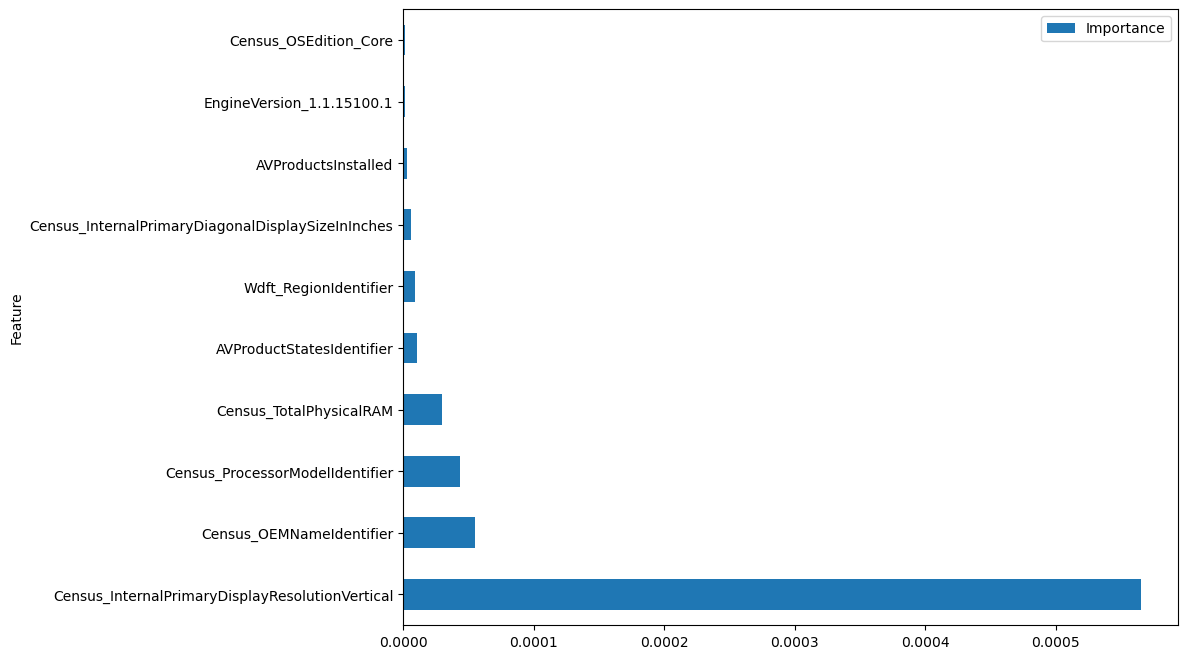

In [66]:
# Obtenemos los coeficientes de la regresión logística que nos muestran la importancia de cada variable en el modelo.
coefficients = Logistic_regression_trained.coef_[0]

feature_importance_LR = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance_LR = feature_importance_LR.sort_values('Importance', ascending=False)
feature_importance_LR.head(10).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))

feature_importance_LR.sort_values(by='Importance',ascending=False)

# parece que para el modelo de Logistic regression una variable muy importante es 'Census_InternalPrimaryDisplayResolutionVertical'.

# Acorde a lo que significa esa variable (Census_InternalPrimaryDisplayResolutionVertical = Retrieves the number of pixels in the vertical direction of the internal display)
# No consideraria a priori que sea una variable de mucha importancia la resolucion de la pantalla a la hora de producirse un hackeo.

<a id='seccion5'></a>
## **5. First Iteracion: XGBoost con CV seleccionando unicamente las columnas que son importantes.**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">


Vamos a evaluar como funciona el XGBoost con las variables que hemos identificado como importantes (mezclaremos las presentes en feature_extr y las importantes para el modelo de XGBoost)

El preprocesamiento es igual que el que hemos utilizado anteriormente asi que utilizaremos el df ya filtrado que lo guardamos previamente en un csv 


In [67]:

# Esta es la lista de las columnas que queremos filtrar.

feature_extr

['AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AppVersion',
 'AvSigVersion',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsTouchEnabled',
 'Census_IsVirtualDevice',
 'Census_MDC2FormFactor',
 'Census_OSVersion',
 'Census_PrimaryDiskTotalCapacity',
 'Census_ProcessorCoreCount',
 'Census_ProcessorModelIdentifier',
 'Census_TotalPhysicalRAM',
 'EngineVersion',
 'HasDetections',
 'IsProtected',
 'OsBuildLab',
 'Wdft_IsGamer']

In [68]:
# y las columnas importantes para el modelo XGBoost_importance
# desde XGB_col_imp eliminamos las variaciones creadas por el OHE y obtenemos esta lista:
# XGB_col_imp 

lista_xgboost=['AVProductsInstalled',
 'Census_IsVirtualDevice',
 'AppVersion',
 'EngineVersion',
 'AppVersion',
 'Census_OSInstallTypeName',
 'Census_OSEdition',
 'IsProtected',
 'Census_TotalPhysicalRAM',
 'Census_OSVersion',
 'Census_ActivationChannel',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'AVProductStatesIdentifier',
 'Census_OSVersion',
 'Wdft_IsGamer']

lista_xgboost= pd.unique(lista_xgboost).tolist()
lista_xgboost

['AVProductsInstalled',
 'Census_IsVirtualDevice',
 'AppVersion',
 'EngineVersion',
 'Census_OSInstallTypeName',
 'Census_OSEdition',
 'IsProtected',
 'Census_TotalPhysicalRAM',
 'Census_OSVersion',
 'Census_ActivationChannel',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'AVProductStatesIdentifier',
 'Wdft_IsGamer']

In [69]:
# y para el logistic regression. recordemos que para este modelo habia una muy importante y el resto en menor medida.
feature_importance_LR= feature_importance_LR.Feature.head(3).to_list()
feature_importance_LR

['Census_InternalPrimaryDisplayResolutionVertical',
 'Census_OEMNameIdentifier',
 'Census_ProcessorModelIdentifier']

In [70]:
# añadimos el target a la lista de variables a filtrar
feature_extr.append('HasDetections')

# y lo unimos todo en una misma lista
best_features= feature_extr + lista_xgboost + feature_importance_LR
best_features= pd.unique(best_features).tolist()
best_features

# obtenemos asi una lista de 23 variables importantes de las 83 iniciales.

['AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AppVersion',
 'AvSigVersion',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsTouchEnabled',
 'Census_IsVirtualDevice',
 'Census_MDC2FormFactor',
 'Census_OSVersion',
 'Census_PrimaryDiskTotalCapacity',
 'Census_ProcessorCoreCount',
 'Census_ProcessorModelIdentifier',
 'Census_TotalPhysicalRAM',
 'EngineVersion',
 'HasDetections',
 'IsProtected',
 'OsBuildLab',
 'Wdft_IsGamer',
 'Census_OSInstallTypeName',
 'Census_OSEdition',
 'Census_ActivationChannel',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_OEMNameIdentifier']

In [71]:
# cargamos nuevamente los datos desde el csv de df_filtered que guardamos anteriormente

df_filtered_1it=pd.read_csv('df_filtered.csv')
df_filtered_1it

,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,OsBuildLab,IsProtected,Census_MDC2FormFactor,Census_OEMNameIdentifier,Census_ProcessorCoreCount,...,Census_OSInstallTypeName,Census_GenuineStateName,Census_ActivationChannel,Census_IsSecureBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,1.1.15100.1,4.18.1807.18075,1.273.1234.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Desktop,1443.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,0.00,11.00,1
1,1.1.15100.1,4.18.1807.18075,1.273.1282.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,2102.00,4.00,...,UUPUpgrade,IS_GENUINE,OEM:DM,0,0.00,0,0.00,1.00,3.00,0
2,1.1.15100.1,4.9.10586.1106,1.273.781.0,46781.00,2.00,10586.1176.amd64fre.th2_release_sec.170913-1848,1.00,Convertible,2206.00,4.00,...,Update,IS_GENUINE,Retail,1,0.00,1,0.00,0.00,15.00,0
3,1.1.15200.1,4.18.1807.18075,1.275.1639.0,53447.00,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,525.00,8.00,...,IBSClean,IS_GENUINE,Retail,1,0.00,0,0.00,0.00,15.00,1
4,1.1.15200.1,4.18.1807.18075,1.275.511.0,47238.00,2.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Notebook,1443.00,4.00,...,Update,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,13.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.1.15200.1,4.18.1807.18075,1.275.1090.0,53447.00,1.00,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.00,Convertible,2102.00,4.00,...,Upgrade,IS_GENUINE,OEM:DM,1,0.00,1,0.00,1.00,10.00,0
499996,1.1.15100.1,4.18.1807.18075,1.273.1620.0,53447.00,1.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,666.00,4.00,...,Upgrade,INVALID_LICENSE,Retail,0,0.00,0,0.00,0.00,15.00,0
499997,1.1.15300.5,4.13.17134.112,1.275.1343.0,53447.00,1.00,17134.1.x86fre.rs4_release.180410-1804,1.00,Desktop,2206.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,8.00,0
499998,1.1.15100.1,4.14.17639.18041,1.273.483.0,43856.00,2.00,16299.15.amd64fre.rs3_release.170928-1534,1.00,Notebook,2668.00,4.00,...,Upgrade,IS_GENUINE,Retail,0,0.00,0,0.00,0.00,1.00,0


In [72]:
df_1= df_filtered_1it[best_features]
df_1

,AVProductStatesIdentifier,AVProductsInstalled,AppVersion,AvSigVersion,Census_IsAlwaysOnAlwaysConnectedCapable,Census_IsTouchEnabled,Census_IsVirtualDevice,Census_MDC2FormFactor,Census_OSVersion,Census_PrimaryDiskTotalCapacity,...,EngineVersion,HasDetections,IsProtected,OsBuildLab,Wdft_IsGamer,Census_OSInstallTypeName,Census_OSEdition,Census_ActivationChannel,Census_InternalPrimaryDisplayResolutionVertical,Census_OEMNameIdentifier
0,53447.00,1.00,4.18.1807.18075,1.273.1234.0,0.00,0,0.00,Desktop,10.0.17134.165,953869.00,...,1.1.15100.1,1,1.00,17134.1.amd64fre.rs4_release.180410-1804,0.00,UUPUpgrade,Professional,OEM:DM,1080.00,1443.00
1,53447.00,1.00,4.18.1807.18075,1.273.1282.0,0.00,0,0.00,Notebook,10.0.17134.165,476940.00,...,1.1.15100.1,0,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,UUPUpgrade,Professional,OEM:DM,720.00,2102.00
2,46781.00,2.00,4.9.10586.1106,1.273.781.0,0.00,1,0.00,Convertible,10.0.10586.1176,244198.00,...,1.1.15100.1,0,1.00,10586.1176.amd64fre.th2_release_sec.170913-1848,0.00,Update,Core,Retail,1080.00,2206.00
3,53447.00,1.00,4.18.1807.18075,1.275.1639.0,0.00,0,0.00,Notebook,10.0.17134.286,228936.00,...,1.1.15200.1,1,1.00,17134.1.amd64fre.rs4_release.180410-1804,0.00,IBSClean,Core,Retail,1080.00,525.00
4,47238.00,2.00,4.18.1807.18075,1.275.511.0,0.00,1,0.00,Notebook,10.0.17134.228,476940.00,...,1.1.15200.1,1,1.00,17134.1.amd64fre.rs4_release.180410-1804,1.00,Update,Professional,OEM:DM,768.00,1443.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,53447.00,1.00,4.18.1807.18075,1.275.1090.0,0.00,1,0.00,Convertible,10.0.16299.492,476940.00,...,1.1.15200.1,0,1.00,16299.431.amd64fre.rs3_release_svc_escrow.1805...,1.00,Upgrade,Core,OEM:DM,768.00,2102.00
499996,53447.00,1.00,4.18.1807.18075,1.273.1620.0,0.00,0,0.00,Notebook,10.0.16299.309,115712.00,...,1.1.15100.1,0,1.00,16299.15.amd64fre.rs3_release.170928-1534,0.00,Upgrade,Core,Retail,720.00,666.00
499997,53447.00,1.00,4.13.17134.112,1.275.1343.0,0.00,0,0.00,Desktop,10.0.17134.285,476940.00,...,1.1.15300.5,0,1.00,17134.1.x86fre.rs4_release.180410-1804,0.00,Upgrade,Professional,Retail,768.00,2206.00
499998,43856.00,2.00,4.14.17639.18041,1.273.483.0,0.00,0,0.00,Notebook,10.0.16299.371,715404.00,...,1.1.15100.1,0,1.00,16299.15.amd64fre.rs3_release.170928-1534,0.00,Upgrade,Professional,Retail,768.00,2668.00


In [73]:
from sklearn.preprocessing import OneHotEncoder


# generamos la df de columnas cat 
df_1_cat= df_1.select_dtypes(include=object)

# y las columnas numericas
df_1_num= df_1.select_dtypes(include='number')

# (sparse=False) en caso de querer matriz densa(guarda 0s). El valor por defecto (True) se recomienda cuando los datos son muy grandes.
encoder = OneHotEncoder(sparse_output= False ,max_categories=6)

# Ajustar y transformar las columnas categóricas
df_1_cat_encoded = encoder.fit_transform(df_1_cat)

# Crear un DataFrame con las columnas categóricas codificadas
df_1_cat_encoded = pd.DataFrame(df_1_cat_encoded, columns=encoder.get_feature_names_out(df_1_cat.columns))

# Concatenar el DataFrame con columnas numéricas (df_num) y el DataFrame codificado
df_1_encoded = pd.concat([df_1_num, df_1_cat_encoded], axis=1)

# Mostrar el DataFrame original y el DataFrame después de la codificación
df_1_encoded

,AVProductStatesIdentifier,AVProductsInstalled,Census_IsAlwaysOnAlwaysConnectedCapable,Census_IsTouchEnabled,Census_IsVirtualDevice,Census_PrimaryDiskTotalCapacity,Census_ProcessorCoreCount,Census_ProcessorModelIdentifier,Census_TotalPhysicalRAM,HasDetections,...,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_Professional,Census_OSEdition_ProfessionalEducation,Census_OSEdition_infrequent_sklearn,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_OEM:NONSLP,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK,Census_ActivationChannel_infrequent_sklearn
0,53447.00,1.00,0.00,0,0.00,953869.00,4.00,2273.00,8192.00,1,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,53447.00,1.00,0.00,0,0.00,476940.00,4.00,2660.00,8192.00,0,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
2,46781.00,2.00,0.00,1,0.00,244198.00,4.00,2998.00,8192.00,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
3,53447.00,1.00,0.00,0,0.00,228936.00,8.00,2880.00,8192.00,1,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
4,47238.00,2.00,0.00,1,0.00,476940.00,4.00,198.00,4096.00,1,...,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,53447.00,1.00,0.00,1,0.00,476940.00,4.00,3397.00,4096.00,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
499996,53447.00,1.00,0.00,0,0.00,115712.00,4.00,2646.00,8192.00,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
499997,53447.00,1.00,0.00,0,0.00,476940.00,4.00,2551.00,4096.00,0,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
499998,43856.00,2.00,0.00,0,0.00,715404.00,4.00,2500.00,6144.00,0,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


In [74]:
# dividimos train test
from sklearn.model_selection import train_test_split

X= df_1_encoded.drop(columns='HasDetections')
y=df_1_encoded['HasDetections']

# vamos a utilizar Random-hold-out como estrategia de validacion ya que tenemos un tamaño de dato suficientemente grande: partición en train/test con un porcentaje de test del 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

In [75]:
import xgboost as xgb
from xgboost import XGBClassifier

# Instanciación del modelo
clf_1 = XGBClassifier() 

# Entrenamiento del modelo
clf_1.fit(X_train, y_train)

# entrenamos nuevamente el modelo elegido para validar si funciona mejor con menos columnas. Lo entrenamos de-novo para que no haya data-leaking.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 5.1 Validacion

In [76]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(
    n_splits=5, # Número de particiones de CV 
    n_repeats=5 # Númro de repeticiones de CV
)

cv_results = cross_validate(
    clf_1,
    X,
    y,
    cv = cv, # Objeto CV definido arriba
    scoring = ['recall', 'accuracy','f1','roc_auc'],
    n_jobs = -1,
)

cv_results

{'fit_time': array([53.37795091, 46.97716284, 51.81091666, 52.89731145, 48.30434561,
        47.39919019, 48.35234666, 51.98008204, 31.09788895, 30.09178424,
        29.13346314, 29.69202304, 30.31386614, 30.44802785, 31.05069518,
        32.79774356, 33.99724054, 30.98038244, 32.27855778, 33.66621804,
        32.28126097, 31.44720149, 31.14509749, 30.53473115, 21.81758547]),
 'score_time': array([1.8076632 , 2.08678699, 1.81224942, 2.16948915, 2.52150083,
        2.27480054, 2.36476088, 2.18212819, 1.98015332, 2.05767703,
        2.01666951, 2.09816337, 1.97245002, 3.4433217 , 2.75212479,
        2.56173706, 2.07665634, 2.19207859, 2.22770309, 2.03289652,
        1.76583862, 1.53977156, 1.53876686, 1.43233013, 1.60898757]),
 'test_recall': array([0.65308082, 0.65534778, 0.65759229, 0.65826073, 0.65761381,
        0.65583166, 0.65825876, 0.65210236, 0.65432641, 0.65411539,
        0.65110555, 0.65598441, 0.65876749, 0.65445651, 0.65615117,
        0.65968828, 0.6531225 , 0.65751318, 0.

In [77]:

# Crear un DataFrame con los resultados de la validación cruzada
cv_results_df = pd.DataFrame({
    'Test': range(1, cv_results['test_recall'].shape[0] + 1),
    'Recall': cv_results['test_recall'],
    'Accuracy': cv_results['test_accuracy'],
    'F1 Score': cv_results['test_f1'],
    'ROC AUC': cv_results['test_roc_auc']
})

# Mostrar el DataFrame

cv_results_df
tabla_metricas_XGB = pd.DataFrame(columns = ['Metrica', 'Media', 'Std_devit'])

In [78]:
tabla_metricas_XGB = pd.DataFrame(columns = ['Metrica', 'Media', 'Std_devit'])
for i in cv_results_df.columns:
    if i=='Test':
        pass
    else:    
        tabla_metricas_XGB.loc[len(tabla_metricas_XGB)] = [i, 
                                                       np.round(np.mean(cv_results_df[i]), 4),
                                                       np.round(np.std(cv_results_df[i]), 4)]


### 5.2 Comprobacion resultados First Iteration

In [79]:
tabla_metricas_baseline

,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.61,0.61,0.60,0.60,0.61
1,Gradient_Boosting,0.61,0.60,0.67,0.64,0.61
2,XGBoost,0.63,0.62,0.66,0.64,0.63
3,Logisitc_Regression,0.55,0.54,0.67,0.60,0.55


In [80]:
tabla_metricas_XGB

# hemos conseguido mejorar el modelo de XGBoost con menos columnas, hemos conseguido mejorar el recall y el f1-score.

,Metrica,Media,Std_devit
0,Recall,0.66,0.00
1,Accuracy,0.62,0.00
2,F1 Score,0.63,0.00
3,ROC AUC,0.67,0.00


<a id='seccion4'></a>
## **6. Second Iteration: Random Forest, Gradient Boosting y XGBoost con optimizacion y cross validation**
<hr style="height:5px;border-width:0;color:orange;background-color:orange">

Aqui vamos a buscar que hiperparametros son los mejores para nuestro modelo. Testearemos nuevamente los 3 modelos elegidos(Random Forest, Gradient Boosting y XGBoost) para ver cual es el que mejor clasifica con unos determinados hiperparámetros.

El proceso es el siguiente:
1. Creacion diccionario con modelos e hiperparametros.
2. Busqueda de hiperparametros por medio de Randomized Search Cross Validation. Utilizamos este porque se ha visto empiricamente que funciona mejor que el GridSearch...y voy un poco escaso de tiempo a decir verdad.
3. Generamos un df donde almacenar las metricas de los 75 modelos testados sobre la que conjeturar.
4. Eleccion del mejor modelo y visualizacion de su performance.

In [81]:

import random

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

### 6.1 Implementacion Randomized Search con Cross Validation

In [94]:
# Instanciamos los modelos y los almacenamos en un diccionario
# junto con los hiperparámetros que queramos optimizar 
classifiers = {
    
    'RandomForest': {
        'model': RandomForestClassifier(n_jobs = -1), 
        'hiperparameters': {
          'criterion': ["gini", "entropy"],
          'max_depth': randint(2, 10),
          'min_samples_leaf': randint(1, 5),
          'n_estimators': randint(10, 100)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    }, 
    'GradientBoosting': {
        'model': GradientBoostingClassifier(), 
        'hiperparameters': {
          'max_depth': randint(2, 10),
          'min_samples_leaf': randint(1, 5),
          'learning_rate': [0.2, 0.1, 0.01],
          'n_estimators': randint(10, 100)
        } # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    },
    'XGBoost': {
        'model': XGBClassifier(objective = 'binary:logistic', n_jobs = -1), 
        'hiperparameters': {
          'max_depth': randint(2, 5),
          'n_estimators': randint(10, 100),
          'learning_rate': [0.2, 0.1, 0.01],
          'subsample': uniform(0.8, 0.2)
        } # https://xgboost.readthedocs.io/en/stable/parameter.html
    }
}

In [82]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

classifiers = {
    'XGBoost': {
        'model': XGBClassifier(objective='binary:logistic', n_jobs=-1, use_label_encoder=False, eval_metric='logloss'), 
        'hiperparameters': {
            'max_depth': randint(2, 5),
            'n_estimators': randint(10, 100),
            'learning_rate': [0.2, 0.1, 0.01],
            'subsample': uniform(0.8, 0.2)
        } # https://xgboost.readthedocs.io/en/stable/parameter.html
    },
    'LogisticRegression': {
        'model': LogisticRegression(n_jobs=-1),
        'hiperparameters': {
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'C': uniform(0.1, 10),
            'solver': ['saga']  # 'saga' solver supports all the penalties
        } # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    }
}


In [83]:
# Iteramos sobre el diccionario anterior, y mediante Random Search 
# vamos optimizando cada uno de los modelos y guardando los resultados
# en un pd.DataFrame

# En best estimators guardaremos los modelos con mejores metricas segun los hiperparametros optimizados

random_search_output = list()
best_estimators = {}
scoring_metrics = ['roc_auc', 'recall', 'accuracy']  # Agrega las métricas que necesitas

for clf_name, clf_info in classifiers.items():
    print(clf_name)
    clf_random_search = RandomizedSearchCV(
        estimator=clf_info['model'], 
        param_distributions=clf_info['hiperparameters'], 
        n_iter=25,
        cv=5,
        scoring=scoring_metrics,  # Utiliza las métricas que necesitas
        return_train_score=True,
        refit='recall',  # Refit utilizando recall, puedes elegir la métrica principal
        n_jobs=-1,
        verbose=3
    )
    clf_random_search.fit(X_train, y_train)
    
    # Resultados del Random Search
    df_output = pd.DataFrame(clf_random_search.cv_results_)
    df_output['clf'] = clf_name
    random_search_output.append(df_output)
    
    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[clf_name] = clf_random_search.best_estimator_

# hemos tardado 39 min de procesado

XGBoost
Fitting 5 folds for each of 25 candidates, totalling 125 fits


LogisticRegression
Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


30 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Usuario\anaconda3\envs\Nuclio\Lib\site-packages\sklearn\li

In [84]:
df_results_1 = pd.concat(random_search_output).reset_index(drop=True)
df_results_1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_roc_auc,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,clf,param_C,param_penalty,param_solver
0,10.73,0.36,0.45,0.01,0.01,2,79,0.88,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.62,...,0.59,0.59,0.58,0.59,0.59,0.00,XGBoost,NaN,NaN,NaN
1,12.45,0.17,0.56,0.02,0.01,3,79,0.81,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.63,...,0.59,0.59,0.59,0.59,0.59,0.00,XGBoost,NaN,NaN,NaN
2,4.80,0.16,0.34,0.01,0.10,2,16,0.95,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.63,...,0.59,0.59,0.59,0.59,0.59,0.00,XGBoost,NaN,NaN,NaN
3,10.83,0.42,0.50,0.03,0.01,3,61,0.92,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.62,...,0.59,0.59,0.59,0.59,0.59,0.00,XGBoost,NaN,NaN,NaN
4,7.25,0.30,0.40,0.01,0.10,2,37,0.93,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.64,...,0.60,0.60,0.60,0.60,0.60,0.00,XGBoost,NaN,NaN,NaN
5,13.16,0.26,0.65,0.06,0.01,4,74,1.00,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.63,...,0.60,0.60,0.60,0.60,0.60,0.00,XGBoost,NaN,NaN,NaN
6,5.98,0.24,0.38,0.01,0.10,2,23,0.80,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.63,...,0.60,0.60,0.60,0.60,0.60,0.00,XGBoost,NaN,NaN,NaN
7,14.50,0.35,0.72,0.02,0.01,4,67,0.95,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.63,...,0.60,0.60,0.60,0.60,0.60,0.00,XGBoost,NaN,NaN,NaN
8,13.91,0.30,0.66,0.06,0.20,2,85,0.95,"{'learning_rate': 0.2, 'max_depth': 2, 'n_esti...",0.65,...,0.61,0.61,0.61,0.61,0.61,0.00,XGBoost,NaN,NaN,NaN
9,8.28,0.26,0.53,0.04,0.01,3,27,0.86,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.62,...,0.58,0.58,0.59,0.58,0.58,0.00,XGBoost,NaN,NaN,NaN


In [511]:
df_results_1 = pd.concat(random_search_output).reset_index(drop=True)
df_results_1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_roc_auc,...,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,clf,param_learning_rate,param_subsample
0,22.5917,0.6016,2.8441,0.1579,entropy,4,3,72,"{'criterion': 'entropy', 'max_depth': 4, 'min_...",0.6307,...,0.5975,0.5979,0.5987,0.5971,0.5966,0.5975,0.0007,RandomForest,NaN,NaN
1,14.4342,3.7211,7.5092,2.1367,gini,4,2,43,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.6294,...,0.5973,0.5971,0.5974,0.5977,0.5974,0.5974,0.0002,RandomForest,NaN,NaN
2,16.6927,0.2943,4.2010,1.0842,gini,2,1,81,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.6262,...,0.5910,0.5920,0.5876,0.5932,0.5901,0.5908,0.0019,RandomForest,NaN,NaN
3,17.8355,3.1498,8.0348,3.6100,gini,2,4,94,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.6243,...,0.5899,0.5917,0.5920,0.5892,0.5901,0.5906,0.0011,RandomForest,NaN,NaN
4,21.9160,2.7360,5.5282,2.3283,gini,9,2,44,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.6403,...,0.6057,0.6062,0.6060,0.6056,0.6066,0.6060,0.0004,RandomForest,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,9.0664,0.3756,0.7428,0.0506,NaN,3,NaN,46,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.6384,...,0.6029,0.6023,0.6025,0.6017,0.6029,0.6025,0.0005,XGBoost,0.1000,0.9036
71,10.2490,0.3228,0.6507,0.0460,NaN,2,NaN,56,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.6121,...,0.5840,0.5843,0.5843,0.5836,0.5845,0.5841,0.0003,XGBoost,0.0100,0.8887
72,13.1694,0.7544,0.9461,0.1363,NaN,4,NaN,59,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",0.6279,...,0.5959,0.5959,0.5964,0.5949,0.5958,0.5958,0.0005,XGBoost,0.0100,0.9277
73,4.7328,0.5772,0.4830,0.0384,NaN,3,NaN,15,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.6113,...,0.5840,0.5841,0.5843,0.5850,0.5845,0.5844,0.0003,XGBoost,0.0100,0.9198


In [85]:
lista_metrics= ['clf', 'params','rank_test_recall','mean_train_recall','mean_test_recall', 'std_train_recall','std_test_recall',       'rank_test_roc_auc','mean_train_roc_auc','mean_test_roc_auc', 'std_train_roc_auc','std_test_roc_auc'      ,'rank_test_accuracy','mean_train_accuracy', 'mean_test_accuracy','std_train_accuracy','std_test_accuracy']
df_results_1[lista_metrics].sort_values(by='rank_test_recall')

,clf,params,rank_test_recall,mean_train_recall,mean_test_recall,std_train_recall,std_test_recall,rank_test_roc_auc,mean_train_roc_auc,mean_test_roc_auc,std_train_roc_auc,std_test_roc_auc,rank_test_accuracy,mean_train_accuracy,mean_test_accuracy,std_train_accuracy,std_test_accuracy
27,LogisticRegression,"{'C': 7.0391775618333465, 'penalty': 'l2', 'so...",1,1.00,1.00,0.00,0.00,2,0.58,0.58,0.00,0.00,10,0.50,0.50,0.00,0.00
44,LogisticRegression,"{'C': 3.293987188840403, 'penalty': 'l2', 'sol...",1,1.00,1.00,0.00,0.00,4,0.58,0.58,0.00,0.00,1,0.50,0.50,0.00,0.00
39,LogisticRegression,"{'C': 3.2737629140122215, 'penalty': 'l1', 'so...",1,1.00,1.00,0.00,0.00,16,0.58,0.58,0.00,0.00,8,0.50,0.50,0.00,0.00
20,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",1,0.69,0.69,0.00,0.00,15,0.63,0.63,0.00,0.00,17,0.60,0.60,0.00,0.00
34,LogisticRegression,"{'C': 4.070724278210883, 'penalty': 'l2', 'sol...",1,1.00,1.00,0.00,0.00,1,0.58,0.58,0.00,0.00,8,0.50,0.50,0.00,0.00
0,XGBoost,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",2,0.69,0.69,0.00,0.00,24,0.62,0.62,0.00,0.00,22,0.59,0.59,0.00,0.00
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",3,0.68,0.68,0.00,0.01,18,0.63,0.63,0.00,0.00,19,0.59,0.59,0.00,0.00
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",4,0.68,0.68,0.01,0.01,17,0.63,0.63,0.00,0.00,15,0.60,0.60,0.00,0.00
28,LogisticRegression,"{'C': 7.9712190022476745, 'penalty': 'none', '...",5,1.00,1.00,0.00,0.00,11,0.58,0.58,0.00,0.00,2,0.50,0.50,0.00,0.00
29,LogisticRegression,"{'C': 5.643030894628953, 'penalty': 'none', 's...",5,1.00,1.00,0.00,0.00,14,0.58,0.58,0.00,0.00,2,0.50,0.50,0.00,0.00


### 6.2 Eleccion del mejor modelo

In [86]:
# Nos quedamos con el mejor modelo de cada tipo
df_best = (
    df_results_1
    .query('(rank_test_recall == 1)|(rank_test_roc_auc == 1)')
    # .drop_duplicates(['clf', 'rank_test_score'])
    
)
df_best= df_best.sort_values(by='rank_test_roc_auc')


In [87]:
df_best.sort_values(by='mean_test_recall',ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_roc_auc,...,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy,clf,param_C,param_penalty,param_solver
34,75.06,0.98,0.22,0.02,NaN,NaN,NaN,NaN,"{'C': 4.070724278210883, 'penalty': 'l2', 'sol...",0.58,...,0.50,0.50,0.50,0.50,0.50,0.00,LogisticRegression,4.07,l2,saga
27,74.85,0.97,0.20,0.00,NaN,NaN,NaN,NaN,"{'C': 7.0391775618333465, 'penalty': 'l2', 'so...",0.58,...,0.50,0.50,0.50,0.50,0.50,0.00,LogisticRegression,7.04,l2,saga
44,76.54,0.55,0.23,0.03,NaN,NaN,NaN,NaN,"{'C': 3.293987188840403, 'penalty': 'l2', 'sol...",0.58,...,0.50,0.50,0.50,0.50,0.50,0.00,LogisticRegression,3.29,l2,saga
39,109.68,0.53,0.23,0.03,NaN,NaN,NaN,NaN,"{'C': 3.2737629140122215, 'penalty': 'l1', 'so...",0.58,...,0.50,0.50,0.50,0.50,0.50,0.00,LogisticRegression,3.27,l1,saga
20,6.78,0.24,0.50,0.03,0.10,3,14,0.90,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.63,...,0.60,0.60,0.60,0.60,0.60,0.00,XGBoost,NaN,NaN,NaN
10,11.86,0.19,0.72,0.03,0.20,4,50,0.92,"{'learning_rate': 0.2, 'max_depth': 4, 'n_esti...",0.66,...,0.62,0.62,0.62,0.62,0.62,0.00,XGBoost,NaN,NaN,NaN


Aqui tengo un comentario sobre la tabla de arriba.
Segun el problema propuesto, yo he definido el recall como la metrica a maximizar ya que es importante que ''cace'' a todos los ordenadores infectados. Sin embargo dependiendo del roc_auc tenemos mejor un modelo u otro. Esto define el rendimiento del modelo.

Elegiremos el XGBoost como mejor modelo basandonos en las metricas anteriores mencionadas.

Vemos algunos valores muy similares en train/test que nos podria sugerir sobre ajuste, pero debido a que no es un valor muy alto proximo a 0.99-1 podriamos hipotizar que aun podemos mejorar el modelo, por ejemplo incluyendo mas columas (lo haremos mas tarde)

In [515]:
split_test_recall_score_columns = ['split0_test_recall','split1_test_recall', 'split2_test_recall', 'split3_test_recall','split4_test_recall']
split_test_roc_auc_score_columns= ['split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc','split4_test_roc_auc']

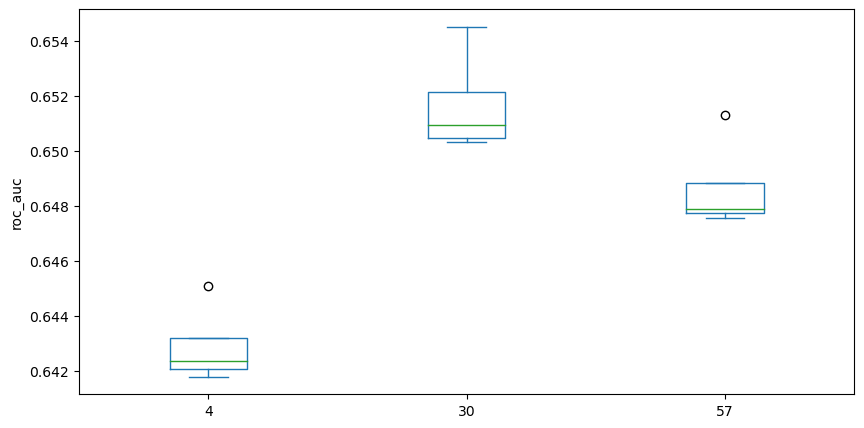

In [518]:
df_best_roc= df_best.query('rank_test_roc_auc ==1')[split_test_roc_auc_score_columns]
df_best_roc.T.plot(kind = 'box', figsize = (10, 5))
plt.ylabel("roc_auc")
plt.show()

Hemos visualizado la distribucion de las metricas a de los mejores tests a lo largo de sus 4 splits en la cross validation y confirmamos que nos quedamos con el XGBoost. Pese a tener mayor recall medio el Random Forest o mayor ROC-AUC el Gradient boosting, en computo global me parece que el XGBoost varia menos y tiene datos mas robustos ante diferentes cambios teniendo un recall bastante alto y el ROC-AUC no muy distinto del Gradient Boosting.

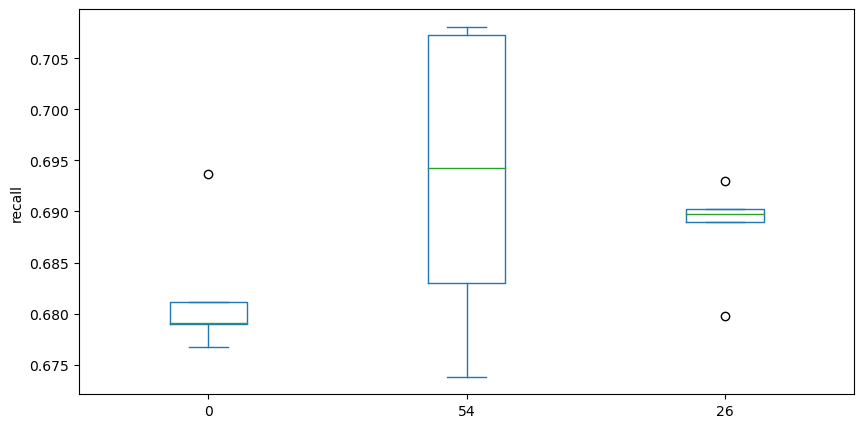

In [519]:
df_best_recall= df_best.query('rank_test_recall ==1')[split_test_recall_score_columns]
df_best_recall.T.plot(kind = 'box', figsize = (10, 5))
plt.ylabel("recall")
plt.show()

In [520]:
# filtramos el modelo que hemos elegido en el diccionario de best stimators que creamos antes para la seleccion de mejor modelo.
best_model = best_estimators['XGBoost']
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=12, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [521]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

In [522]:
# Obtenemos su rendimiento (ROC AUC) sobre los datos de test 
y_prob = best_model.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)

0.6159444897757917

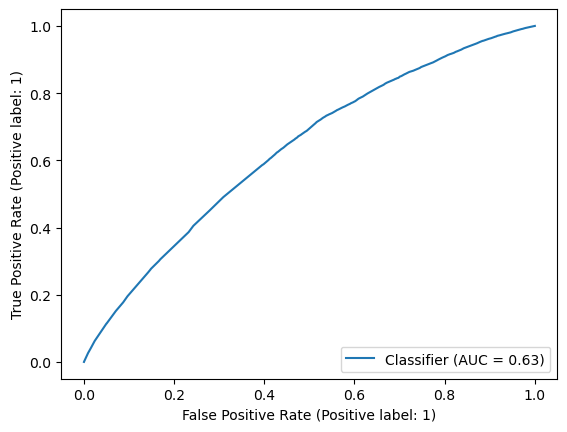

In [523]:
# Vemos la curva ROC asociada
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

Tenemos un modelo que clasifica con una tasa de acierto de 62% (62 veces de cada 100 acierta).

<a id='seccion7'></a>
## 7. Third Iteration: Utilizar XGBoost Optimizado segun hiperparametros ampliando mas datos (20 columnas + target)


In [524]:
XGB_col_imp

# hemos seleccionado las columas de mayor importancia para el XGBoost y almacenadas en la variable XGB_col_imp. Esto se hizo en el apartado de feature importance si quieres consultar.

['AVProductsInstalled',
 'Census_IsVirtualDevice',
 'Census_OSSkuName_CORE_COUNTRYSPECIFIC',
 'EngineVersion_1.1.15000.2',
 'Census_PowerPlatformRoleName_SOHOServer',
 'Census_OSInstallTypeName_Other',
 'Census_TotalPhysicalRAM',
 'Census_OSEdition_CoreCountrySpecific',
 'EngineVersion_1.1.14600.4',
 'EngineVersion_1.1.15100.1',
 'IsProtected',
 'Census_OSVersion_10.0.17134.285',
 'Census_ActivationChannel_Retail',
 'AVProductStatesIdentifier',
 'Census_OSVersion_10.0.17134.165',
 'AppVersion_4.18.1806.18062',
 'EngineVersion_1.1.14901.4',
 'Wdft_IsGamer',
 'AppVersion_4.18.1807.18075',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_PrimaryDiskTotalCapacity',
 'AppVersion_4.13.17134.1']

In [525]:
XGB_col_imp_3= ['AVProductsInstalled',
 'Census_IsVirtualDevice',
 'Census_OSSkuName',
 'EngineVersion',
 'Census_PowerPlatformRoleName',
 'Census_OSInstallTypeName',
 'Census_TotalPhysicalRAM',
 'Census_OSEdition',
 'EngineVersion',
 'EngineVersion',
 'IsProtected',
 'Census_OSVersion',
 'Census_ActivationChannel',
 'AVProductStatesIdentifier',
 'Census_OSVersion',
 'AppVersion',
 'EngineVersion',
 'Wdft_IsGamer',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_PrimaryDiskTotalCapacity']
XGB_col_imp_3.append('HasDetections')

<a id='seccion5'></a>
### Preprocesamiento como siempre

In [526]:
df_3=pd.read_csv('sample_mmp.csv',encoding='UTF-8',sep=',',index_col=0).reset_index(drop=True)
df_3.Census_PrimaryDiskTotalCapacity = df_3.Census_PrimaryDiskTotalCapacity.astype(float)
df_3.SMode= df_3.SMode.astype(float)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_7988\1740234191.py:1: DtypeWarning:

Columns (29,42) have mixed types. Specify dtype option on import or set low_memory=False.



In [527]:
df_3[XGB_col_imp_3]

,AVProductsInstalled,Census_IsVirtualDevice,Census_OSSkuName,EngineVersion,Census_PowerPlatformRoleName,Census_OSInstallTypeName,Census_TotalPhysicalRAM,Census_OSEdition,EngineVersion,EngineVersion,...,Census_OSVersion,Census_ActivationChannel,AVProductStatesIdentifier,Census_OSVersion,AppVersion,EngineVersion,Wdft_IsGamer,Census_IsAlwaysOnAlwaysConnectedCapable,Census_PrimaryDiskTotalCapacity,HasDetections
0,1.0000,0.0000,PROFESSIONAL,1.1.15100.1,Desktop,UUPUpgrade,8192.0000,Professional,1.1.15100.1,1.1.15100.1,...,10.0.17134.165,OEM:DM,53447.0000,10.0.17134.165,4.18.1807.18075,1.1.15100.1,0.0000,0.0000,953869.0000,1
1,1.0000,0.0000,PROFESSIONAL,1.1.15100.1,Mobile,UUPUpgrade,8192.0000,Professional,1.1.15100.1,1.1.15100.1,...,10.0.17134.165,OEM:DM,53447.0000,10.0.17134.165,4.18.1807.18075,1.1.15100.1,1.0000,0.0000,476940.0000,0
2,2.0000,0.0000,CORE,1.1.15100.1,Mobile,Update,8192.0000,Core,1.1.15100.1,1.1.15100.1,...,10.0.10586.1176,Retail,46781.0000,10.0.10586.1176,4.9.10586.1106,1.1.15100.1,0.0000,0.0000,244198.0000,0
3,1.0000,0.0000,CORE,1.1.15200.1,Mobile,IBSClean,8192.0000,Core,1.1.15200.1,1.1.15200.1,...,10.0.17134.286,Retail,53447.0000,10.0.17134.286,4.18.1807.18075,1.1.15200.1,0.0000,0.0000,228936.0000,1
4,2.0000,0.0000,PROFESSIONAL,1.1.15200.1,Mobile,Update,4096.0000,Professional,1.1.15200.1,1.1.15200.1,...,10.0.17134.228,OEM:DM,47238.0000,10.0.17134.228,4.18.1807.18075,1.1.15200.1,1.0000,0.0000,476940.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1.0000,0.0000,CORE,1.1.15200.1,Mobile,Upgrade,4096.0000,Core,1.1.15200.1,1.1.15200.1,...,10.0.16299.492,OEM:DM,53447.0000,10.0.16299.492,4.18.1807.18075,1.1.15200.1,1.0000,0.0000,476940.0000,0
499996,1.0000,0.0000,CORE,1.1.15100.1,Mobile,Upgrade,8192.0000,Core,1.1.15100.1,1.1.15100.1,...,10.0.16299.309,Retail,53447.0000,10.0.16299.309,4.18.1807.18075,1.1.15100.1,0.0000,0.0000,115712.0000,0
499997,1.0000,0.0000,PROFESSIONAL,1.1.15300.5,Desktop,Upgrade,4096.0000,Professional,1.1.15300.5,1.1.15300.5,...,10.0.17134.285,Retail,53447.0000,10.0.17134.285,4.13.17134.112,1.1.15300.5,0.0000,0.0000,476940.0000,0
499998,2.0000,0.0000,PROFESSIONAL,1.1.15100.1,Mobile,Upgrade,6144.0000,Professional,1.1.15100.1,1.1.15100.1,...,10.0.16299.371,Retail,43856.0000,10.0.16299.371,4.14.17639.18041,1.1.15100.1,0.0000,0.0000,715404.0000,0


In [528]:
for i in df_3.columns:
    if df_3[i].isna().sum() != 0:
        # Verificar si todos los valores únicos son numéricos, devolverá false si existe alguno no numerico(lo transforma en NaN y luego en serie booleana al pasar el notna().Al pasar el all devuelve si al menos es NaN..>no es numerica esa columna)
        if pd.to_numeric(df_3[i], errors='coerce').notna().all():
            # Para datos binarios aplicamos la moda
            if df_3[i].max() == 1 and df_3[i].min() == 0:
                df_3[i].fillna(value=-1, inplace=True)
        
        # Para datos string aplicamos palabra ''UNKNOWN'
        elif df_3[i].dtype == 'O':  # 'O' representa datos de tipo string en pandas
            df_3[i].fillna('UNKNOWN', inplace=True)

        # Para datos numéricos continuos aplicamos la mediana.
        else:
            df_3[i].fillna(value=-1, inplace=True)


df_3.isna().sum()

MachineIdentifier                          0
ProductName                                0
EngineVersion                              0
AppVersion                                 0
AvSigVersion                               0
                                          ..
Census_IsPenCapable                        0
Census_IsAlwaysOnAlwaysConnectedCapable    0
Wdft_IsGamer                               0
Wdft_RegionIdentifier                      0
HasDetections                              0
Length: 83, dtype: int64

In [529]:
# generamos la df de columnas cat 
df_3_cat= df_3.select_dtypes(include=object)

# y las columnas numericas
df_3_num= df_3.select_dtypes(include='number')

In [530]:
# Encoding
from sklearn.preprocessing import OneHotEncoder


# (sparse=False) en caso de querer matriz densa(guarda 0s). El valor por defecto (True) se recomienda cuando los datos son muy grandes.
encoder = OneHotEncoder(sparse= False ,max_categories=6)

# Ajustar y transformar las columnas categóricas
df_3_cat_encoded = encoder.fit_transform(df_3_cat)

# Crear un DataFrame con las columnas categóricas codificadas
df_3_cat_encoded = pd.DataFrame(df_3_cat_encoded, columns=encoder.get_feature_names_out(df_3_cat.columns))

# Concatenar el DataFrame con columnas numéricas (df_num) y el DataFrame codificado
df_3_encoded = pd.concat([df_3_num, df_3_cat_encoded], axis=1)

# Mostrar el DataFrame original y el DataFrame después de la codificación
df_3_encoded

# hemos pasado de 146 columnas de antes a 209 columnas...esperaba un aumento mayor de la dimensionalidad (hemos pasado de 8(iteracion 1 y 2) a 22 columnas del df)

c:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_ActivationChannel_Volume:MAK,Census_ActivationChannel_infrequent_sklearn,Census_FlightRing_NOT_SET,Census_FlightRing_RP,Census_FlightRing_Retail,Census_FlightRing_Unknown,Census_FlightRing_WIS,Census_FlightRing_infrequent_sklearn
0,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,8,85219.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,129,54198.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,0,7.0000,0,-1.0000,46781.0000,2.0000,1.0000,1,149,122689.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,164,114587.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,0,7.0000,0,-1.0000,47238.0000,2.0000,1.0000,1,207,72421.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,85,129210.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
499996,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,149,80920.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
499997,0,7.0000,0,-1.0000,53447.0000,1.0000,1.0000,1,93,4342.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
499998,0,7.0000,0,-1.0000,43856.0000,2.0000,1.0000,1,195,10222.0000,...,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [531]:
# dividimos train test
from sklearn.model_selection import train_test_split

X= df_3_encoded.drop(columns='HasDetections')
y=df_3_encoded['HasDetections']

# vamos a utilizar Random-hold-out como estrategia de validacion ya que tenemos un tamaño de dato suficientemente grande: partición en train/test con un porcentaje de test del 33%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

In [532]:
#Entrenamos el modelo que hemos creado con los nuevos datos.

# Instanciación del modelo
clf_3 = best_model 

# Entrenamiento del modelo
clf_3.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=12, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [533]:
# hacemos la validacion cruzada del modelo para aumentar robustez. Añadimos las metricas que me interesa visualizar (importante recall y ROC-AUC y el resto por contrastar y curiosidad)

from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(
    n_splits=5, # Número de particiones de CV 
    n_repeats=5 # Númro de repeticiones de CV
)

cv_results = cross_validate(
    clf_3,
    X,
    y,
    cv = cv, # Objeto CV definido arriba
    scoring = ['recall', 'accuracy','f1','roc_auc'],
    n_jobs = -1,
)

cv_results

c:\Users\Usuario\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



{'fit_time': array([102.7288599 , 116.34651637,  84.60010076,  75.27197814,
        117.54254913,  72.83053493,  85.96792102,  85.52932501,
         59.54933167,  59.30091286,  48.25343633,  48.46265507,
         48.45433378,  42.85267639,  36.88856983,  39.57508564,
         29.90998459,  34.97161055,  43.02183962,  42.14910674,
         37.77882934,  36.85692453,  36.43800879,  35.81922626,
         31.05670857]),
 'score_time': array([5.9804697 , 4.22750258, 7.37332678, 3.66101909, 4.59343696,
        3.95381618, 3.76756573, 3.04963422, 1.49914908, 1.50874996,
        1.94515681, 1.92533588, 2.25607991, 2.16222906, 2.41825604,
        1.72412705, 3.25341964, 4.0936563 , 2.35092258, 2.20469809,
        2.19087315, 1.61490488, 1.59976983, 1.36791253, 0.90489769]),
 'test_recall': array([0.60704992, 0.61666734, 0.62294951, 0.56428144, 0.61500509,
        0.62268745, 0.60383393, 0.64484629, 0.62320493, 0.6236239 ,
        0.62126877, 0.62066888, 0.62177023, 0.60870606, 0.60170988,
     

In [534]:
# Crear un DataFrame con los resultados de la validación cruzada
cv_results_df = pd.DataFrame({
    'Test': range(1, cv_results['test_recall'].shape[0] + 1),
    'Recall': cv_results['test_recall'],
    'Accuracy': cv_results['test_accuracy'],
    'F1 Score': cv_results['test_f1'],
    'ROC AUC': cv_results['test_roc_auc']
})

# Mostrar el DataFrame

cv_results_df
tabla_metricas_XGB_3 = pd.DataFrame(columns = ['Metrica', 'Media', 'Std_devit'])

In [535]:
tabla_metricas_XGB_3 = pd.DataFrame(columns = ['Metrica', 'Media', 'Std_devit'])
for i in cv_results_df.columns:
    if i=='Test':
        pass
    else:    
        tabla_metricas_XGB_3.loc[len(tabla_metricas_XGB_3)] = [i, 
                                                       np.round(np.mean(cv_results_df[i]), 4),
                                                       np.round(np.std(cv_results_df[i]), 4)]

### 6.2 Tabla metricas XGBoost Optimizado

In [536]:
tabla_metricas_XGB_3

,Metrica,Media,Std_devit
0,Recall,0.6159,0.0140
1,Accuracy,0.6207,0.0014
2,F1 Score,0.6188,0.0055
3,ROC AUC,0.6740,0.0016


Vemos que respecto a nuestro primer modelo XGBoost las metricas han cambiado. Tenemos una mejora de Recall significativa (+0.03 respecto a Iteracion 2 y de +0.05 respecto baseline) 

Sin embargo aumenta los valores generales de las varianzas y consecuentemente las desviaciones estandar del CV del  modelo. Esto lo achaco  a la introduccion de mas columnas a analizar (de 8 a 21).

In [537]:
tabla_metricas_XGB

,Metrica,Media,Std_devit
0,Recall,0.6755,0.0026
1,Accuracy,0.6101,0.0012
2,F1 Score,0.6340,0.0017
3,ROC AUC,0.6503,0.0011


In [538]:
tabla_metricas_baseline


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Random Forest,0.6170,0.6200,0.6090,0.6150,0.6170
1,Gradient_Boosting,0.6150,0.6050,0.6690,0.6350,0.6150
2,XGBoost,0.6310,0.6250,0.6560,0.6400,0.6310
3,Logisitc_Regression,0.5010,0.5010,0.9940,0.6660,0.5000


In [539]:
# vamos a visualizar el rendimiento de dicho modelo.
# Obtenemos su rendimiento (ROC AUC) sobre los datos de test 
y_prob = best_model.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_pred)

0.6159444897757917

### 6.3 Curva ROC-AUC

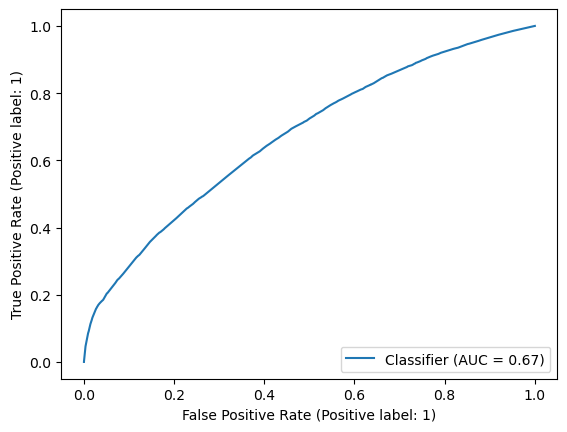

In [540]:
# Vemos la curva ROC asociada
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.show()

La grafica curva ROC-AUC me esperaba que mejorara mas. Sin embargo algo ha mejorado tanto en forma como en puntuacion respecto a la primera curva roc que vimos.

## Conclusion

Hemos conseguido mejorar el modelo!

Tanto las metricas han mejorado respecto al baseline (Recall:0.6560 vs 0.7055) como el rendimiento visualizado en la curva ROC-AUC (AUC: 0.62 vs 0.65).

Me gustaría seguir optimizando el modelo pero por la falta de tiempo para la entrega me veo incapaz. 

Las cosas que me gustaría seguir investigando son las siguientes:
1. Investigar las columnas de nulos de alta proporcion de nulos que eliminamos al principio (el punto de corte lo pusimos en >30000 nulos, más de un 6% de nulos en columna). Se me ocurre aislar los datos sin nulos e ir probando si mejora el modelo usando dichos datos o ir modificando dicho punto de corte. La pregunta que me hago es: ¿y si en esas columnas existian las claves para que el modelo clasifique mejor?
2. Probar otros modelos no basados en arboles. Inicialmente valoré esta opcion pero dado el alto tiempo de procesado aborté esta alternativa.
3. Hacer distintos cortes de las categorias maximas en el OHE.
4. Utilizar Binary encoder para las variables categoricas que tengan mas representacion vs ''otros''
5. Buscar nuevas formas de analizar la correlacion de las variables con la variable target. La funcion corr() usa la correlacion de Pearson que cuantifica las correlaciones lineales pero el resto no (relaciones exponenciles, ausencia de analisis de correlacion de variables categoricas...). La biblioteca PhiK seria un aspecto que me gustaria probar e implementar con el objetivo de tener mayor insigth sobre la importancia de las variables. De esta forma al modelo podria pasarle dichas columnas con la esperanza de que mejore el performance.(riesgo de overfiting por aumento de complejidad?)
6.  Codigo mas sencillo. Soy consciente que hay bastantes ñapas de programacion (sobretodo cortapega de codigo), y me hubiera gustado tomarme el tiempo para pensar y construir funciones para automatizar los procesos.

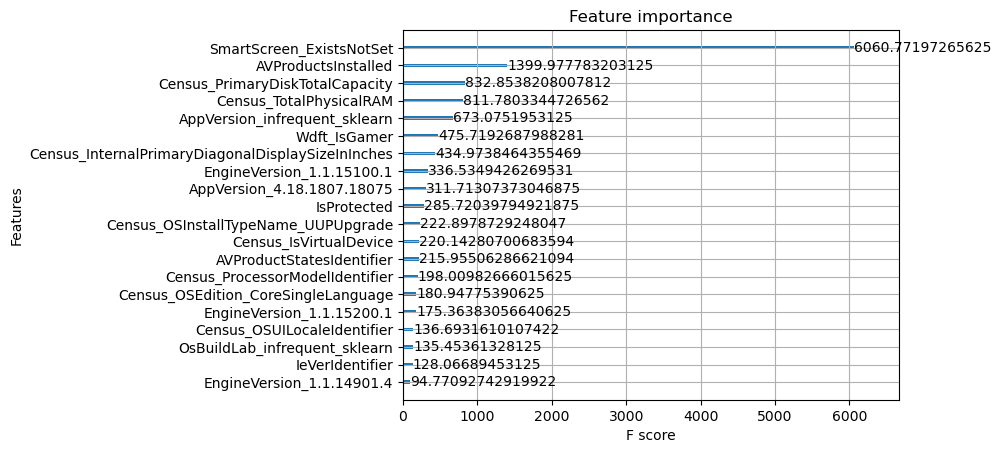

In [541]:
from xgboost import plot_importance

# Criterio de importancia: ganancia de información, AQUI PUEDES PONER DISTINTOS VALORES, gain, weigth, cover...
plot_importance(best_model, importance_type = 'gain', max_num_features=20)
plt.show()

Aqui podemos ver las Features importances de nuestro mejor modelo. Al parecer que tenga o no pantalla el ordenador es muy importante y tiene sentido ya que probablemente si no tiene pantalla se trate de algun ordenador de servidores.

Me gustaría dedicarle algo mas de cariño a la interpretacion del modelo y de las variables...pero esto exhausto. Hasta aqui llego.
